In [2]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from relaynet import RelayNet, DenseBlock
from data_utils import get_imdb_data
from train import valid
from utils import error_map_dice

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/magnus/Documents/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 88
Test size: 22


In [4]:
# Best model with epoch 35 and dice 0.785227277062156
relay_net = RelayNet(dropout_prob=0, basic_block=DenseBlock)
relay_net.load_state_dict(torch.load('models_dense/model-35.model'))
relay_net = relay_net.cuda()
relay_net.eval()

In [6]:
args = namedtuple('Args', ['batch_size', 'cuda'])
valid(test_data, relay_net, args(batch_size=4, cuda=True))

100%|██████████| 11/11 [00:00<00:00, 11.20it/s]

Validation dice avg: 0.7841881025921215


0.7841881025921215

/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


Image 0


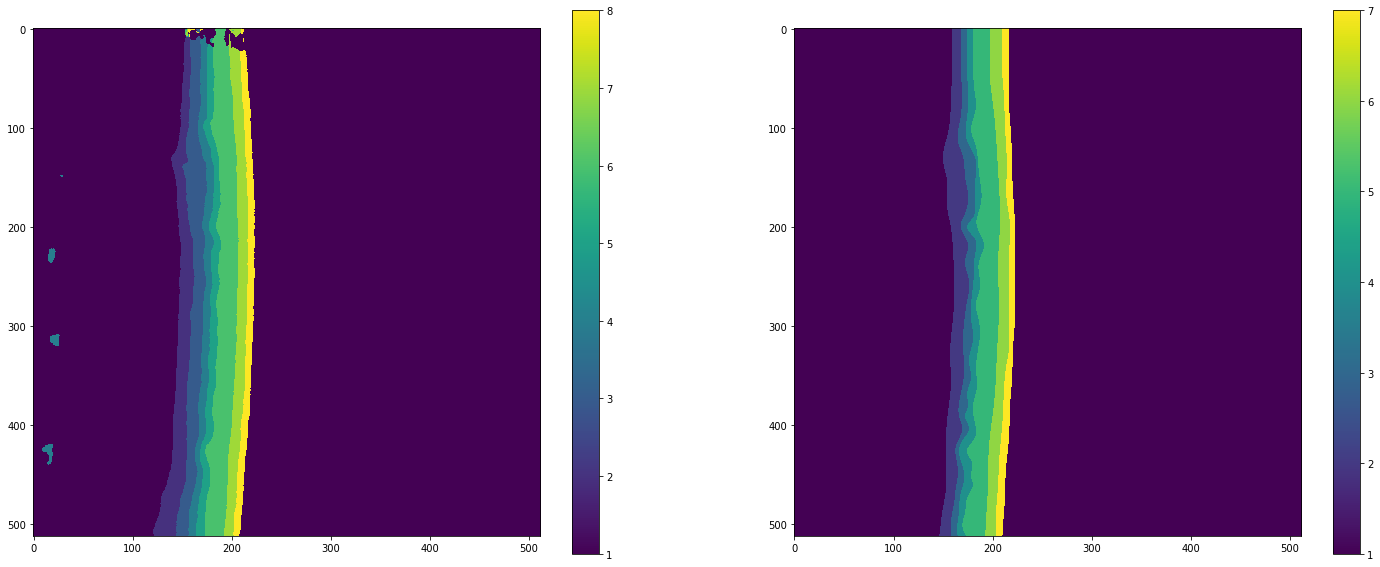

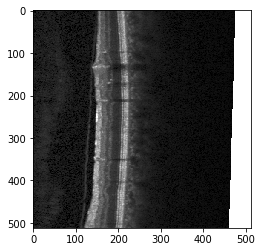

Image 1


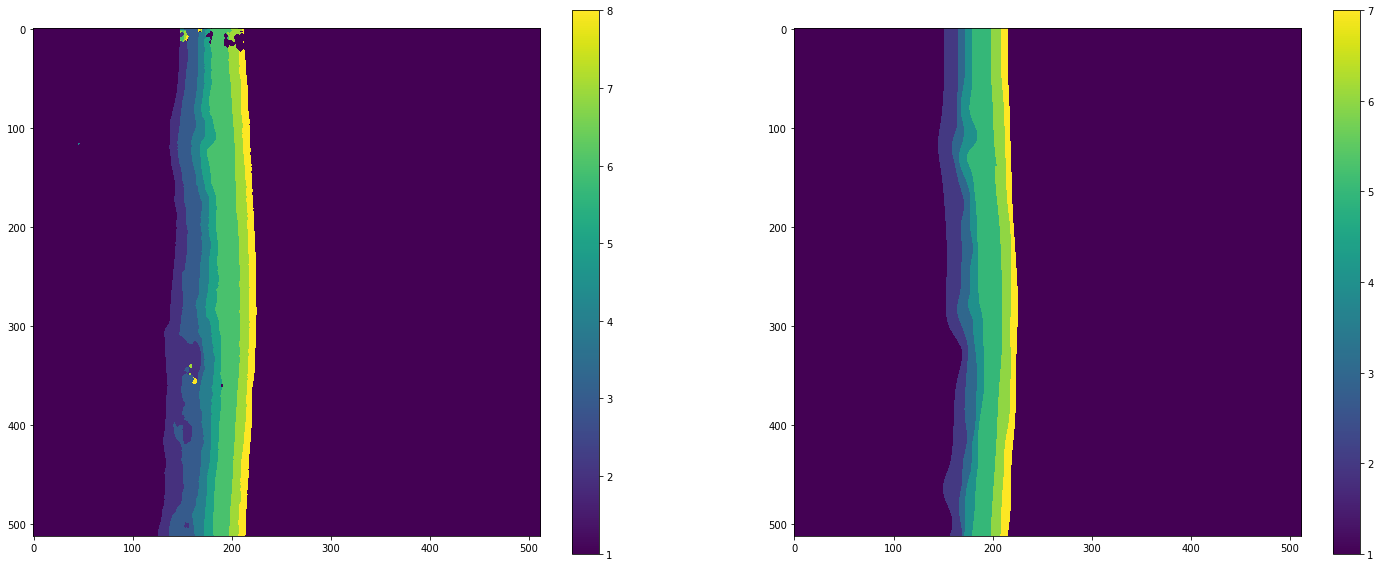

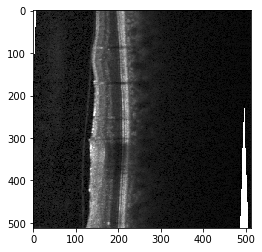

Image 2


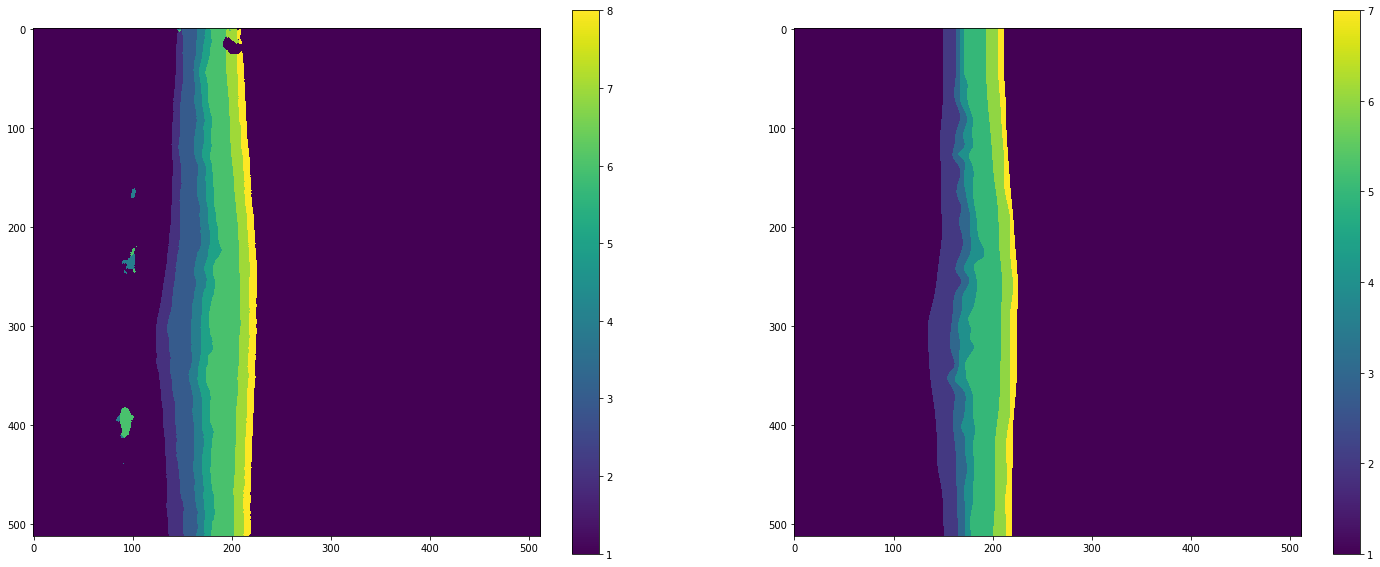

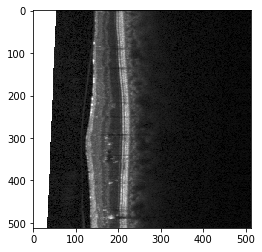

Image 3


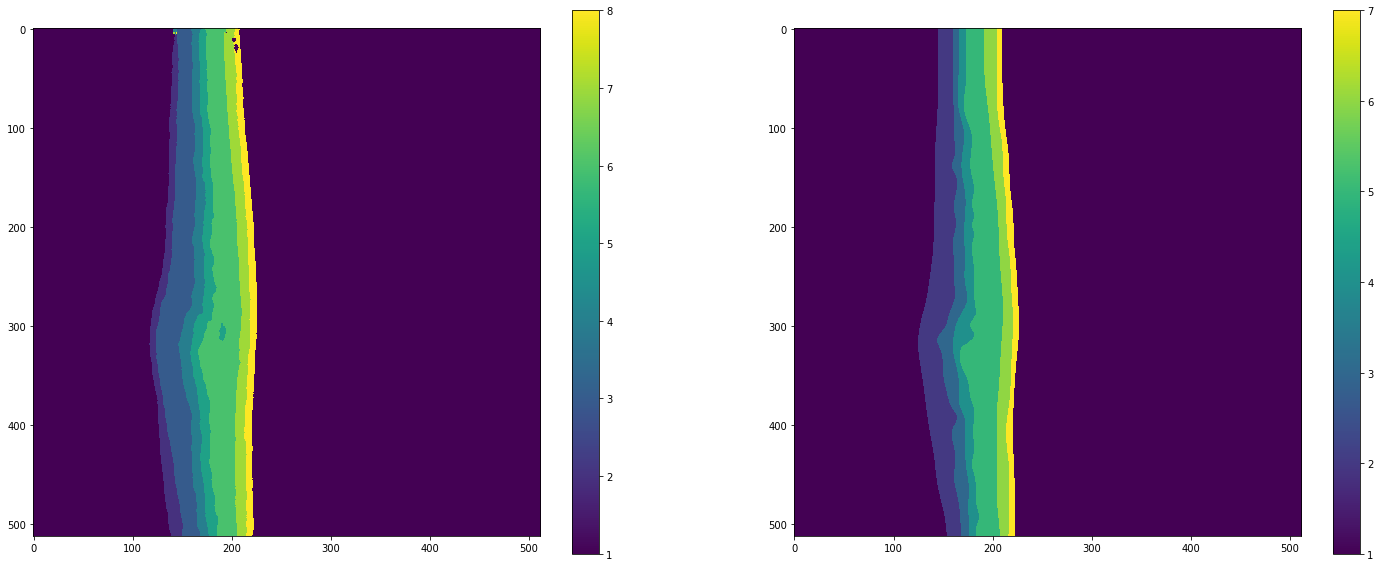

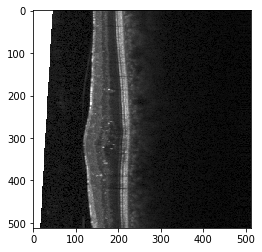

Image 4


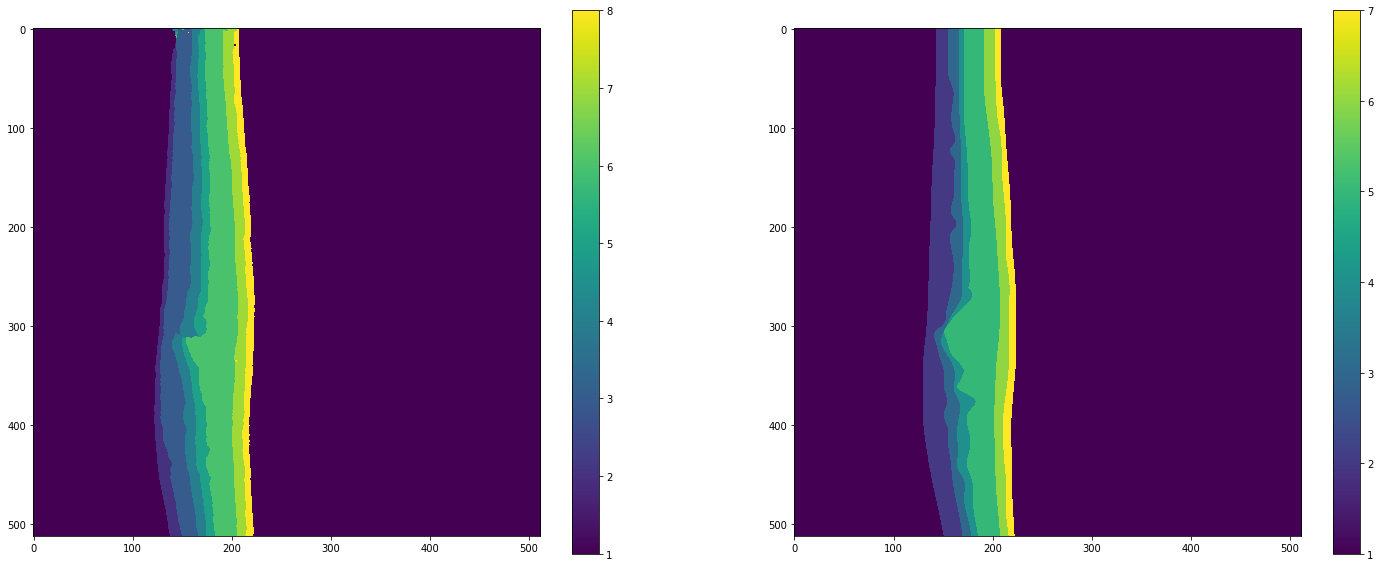

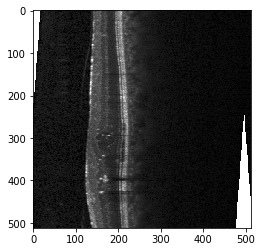

Image 5


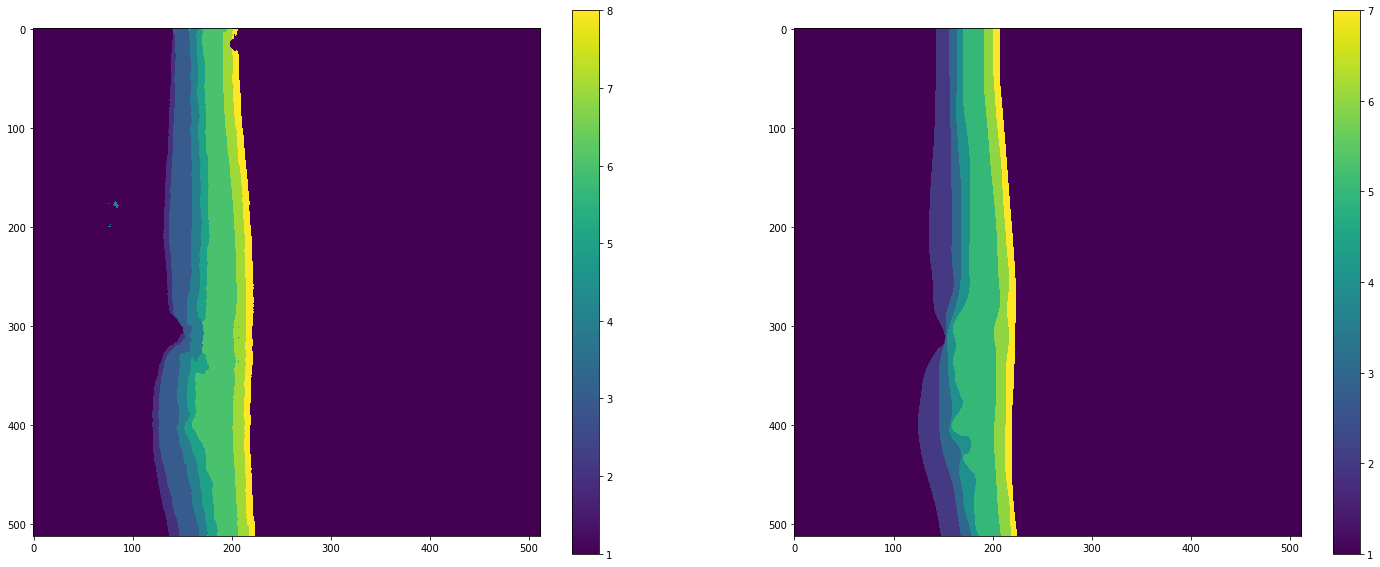

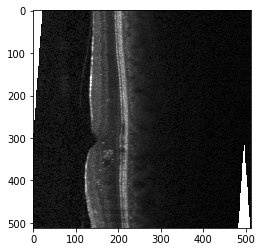

Image 6


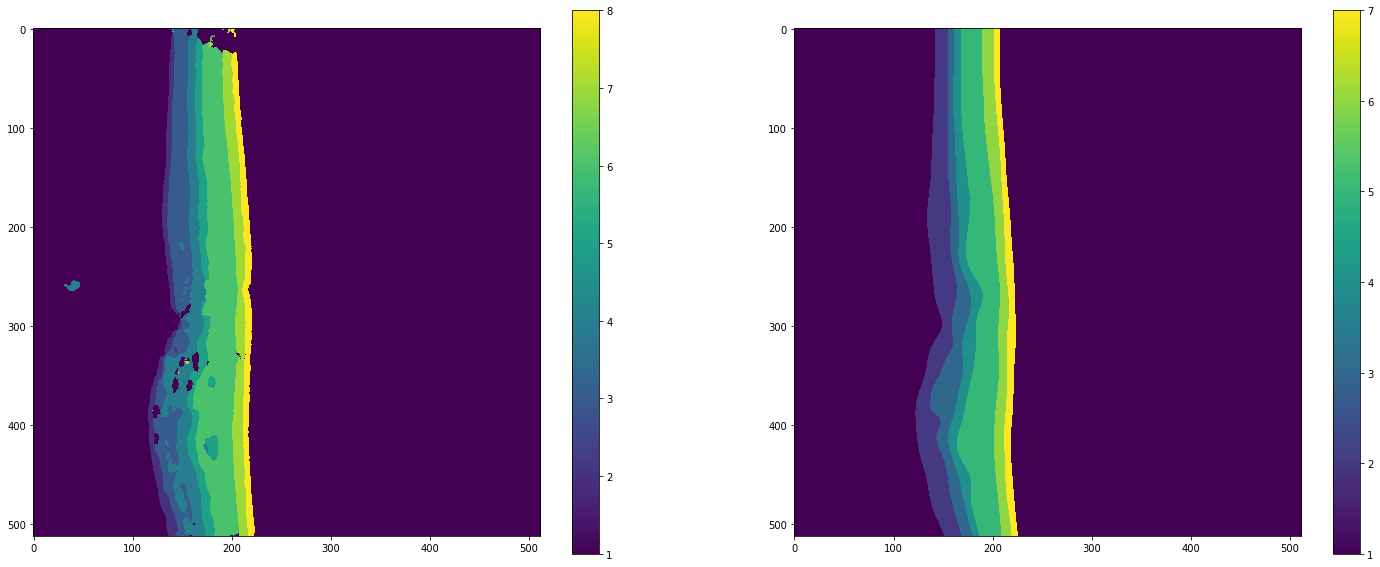

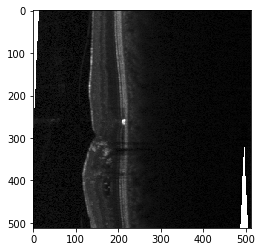

Image 7


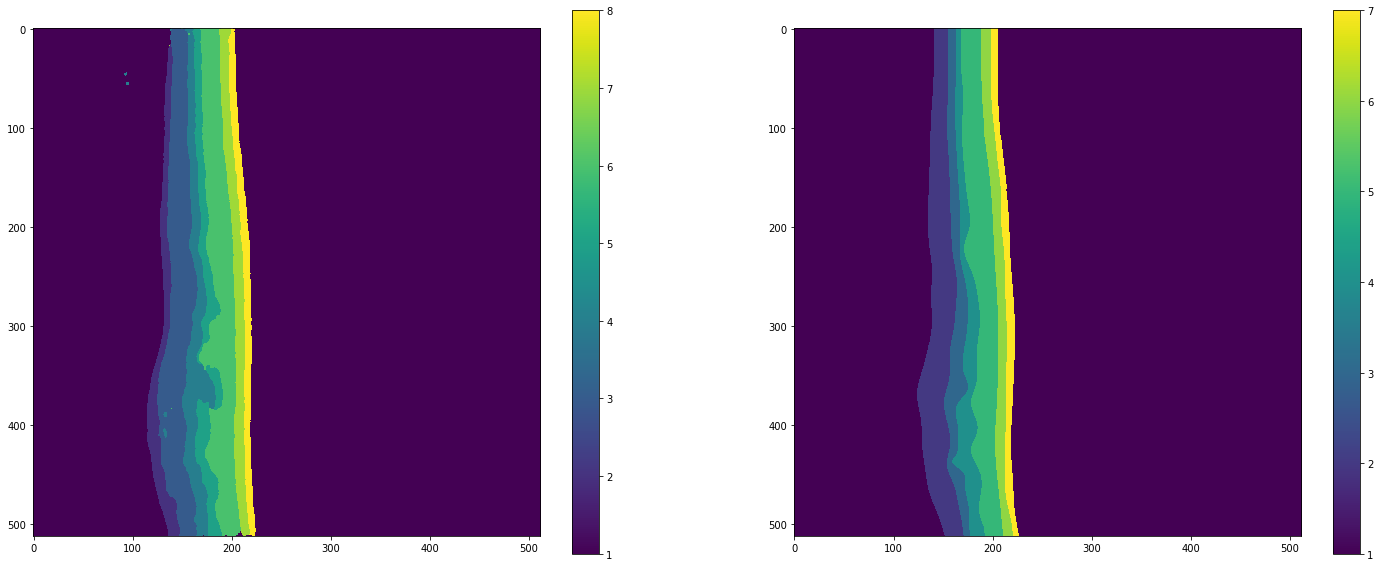

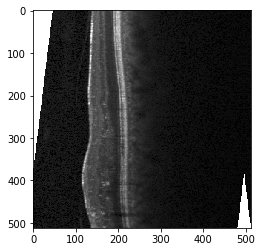

Image 8


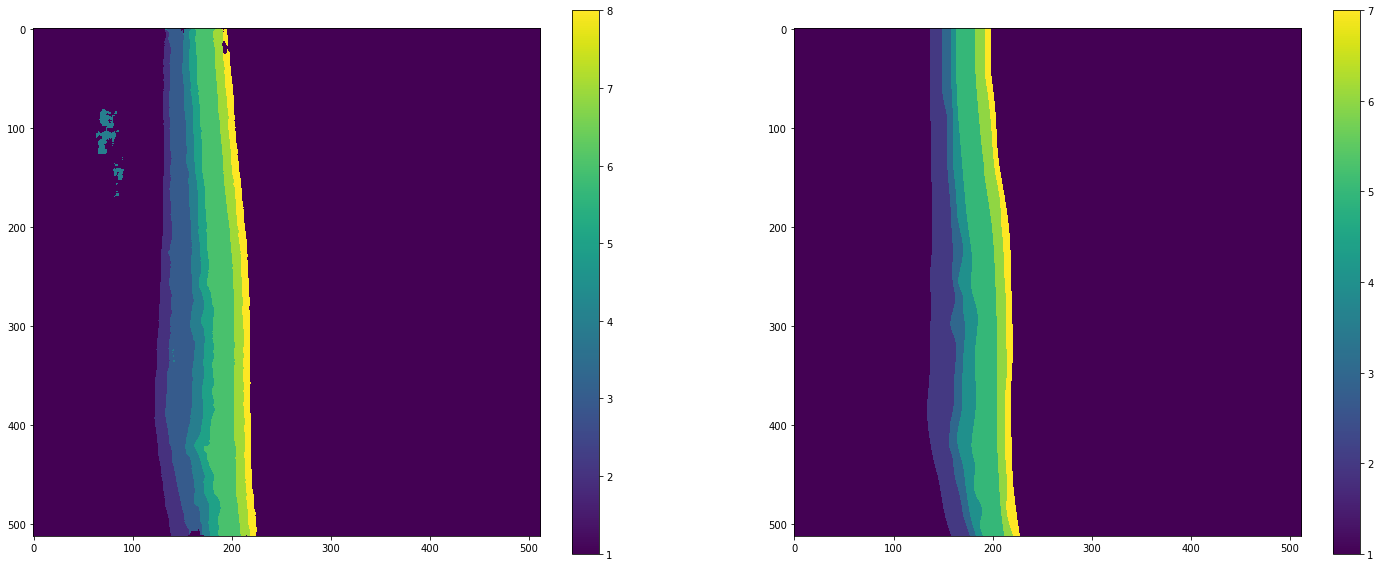

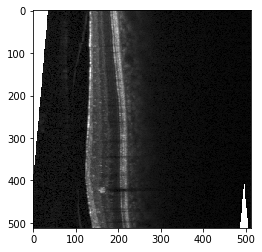

Image 9


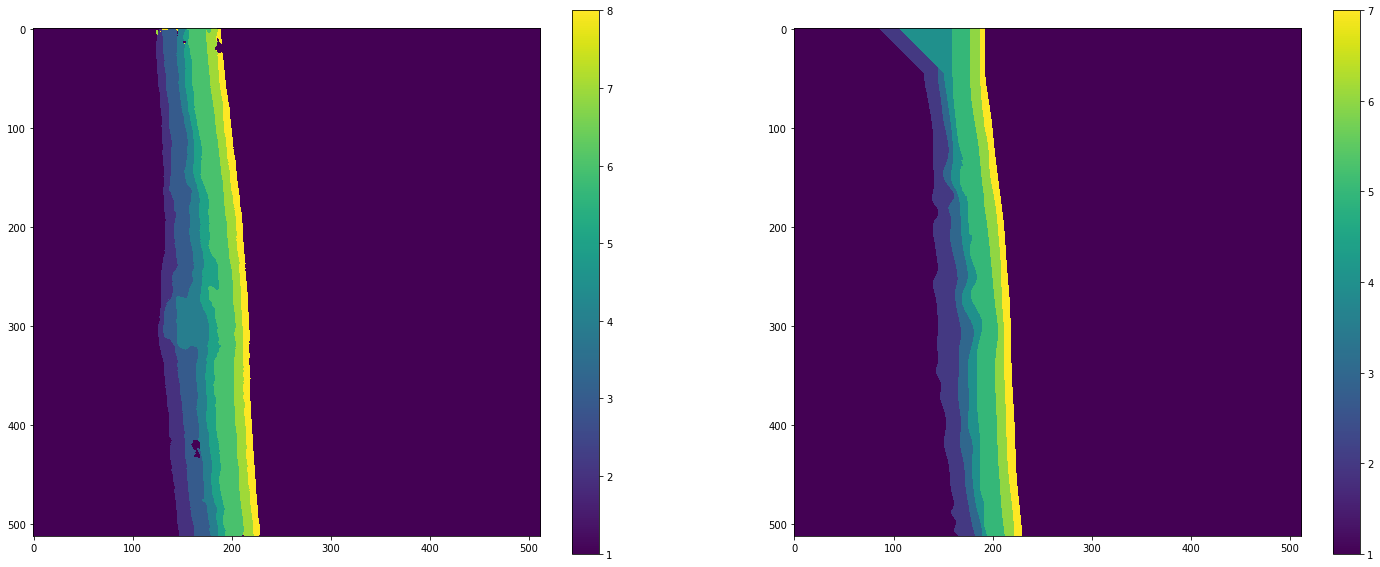

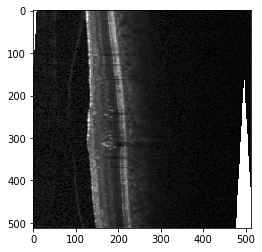

Image 10


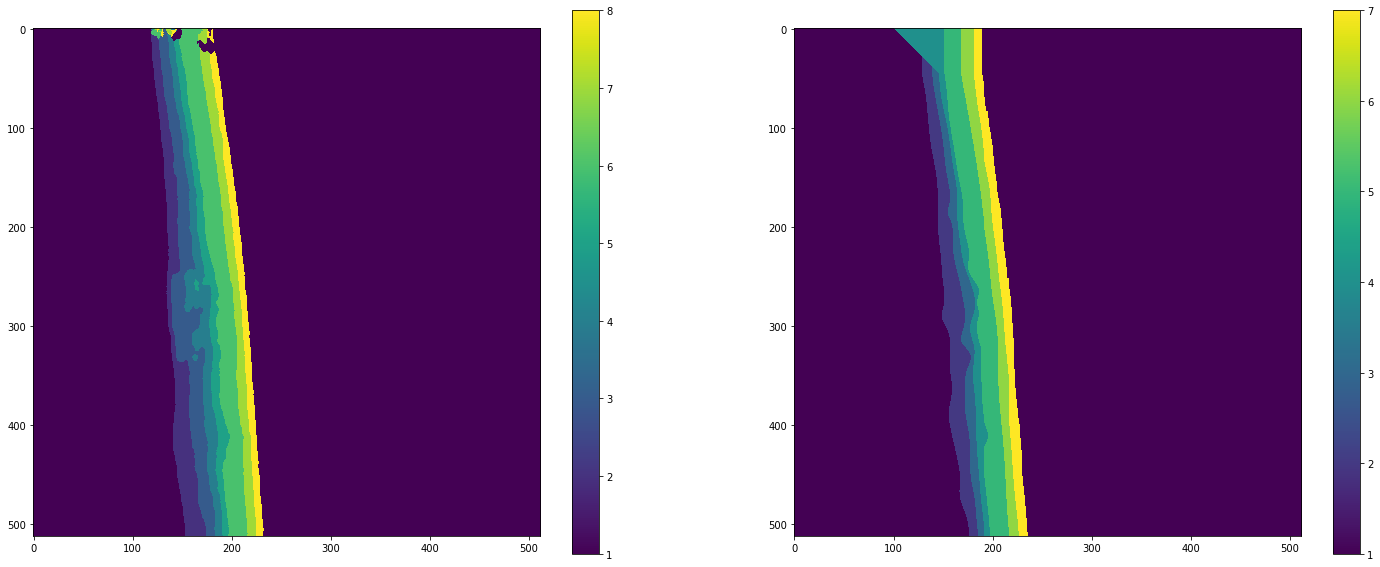

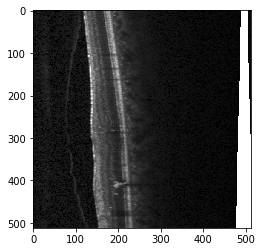

Image 11


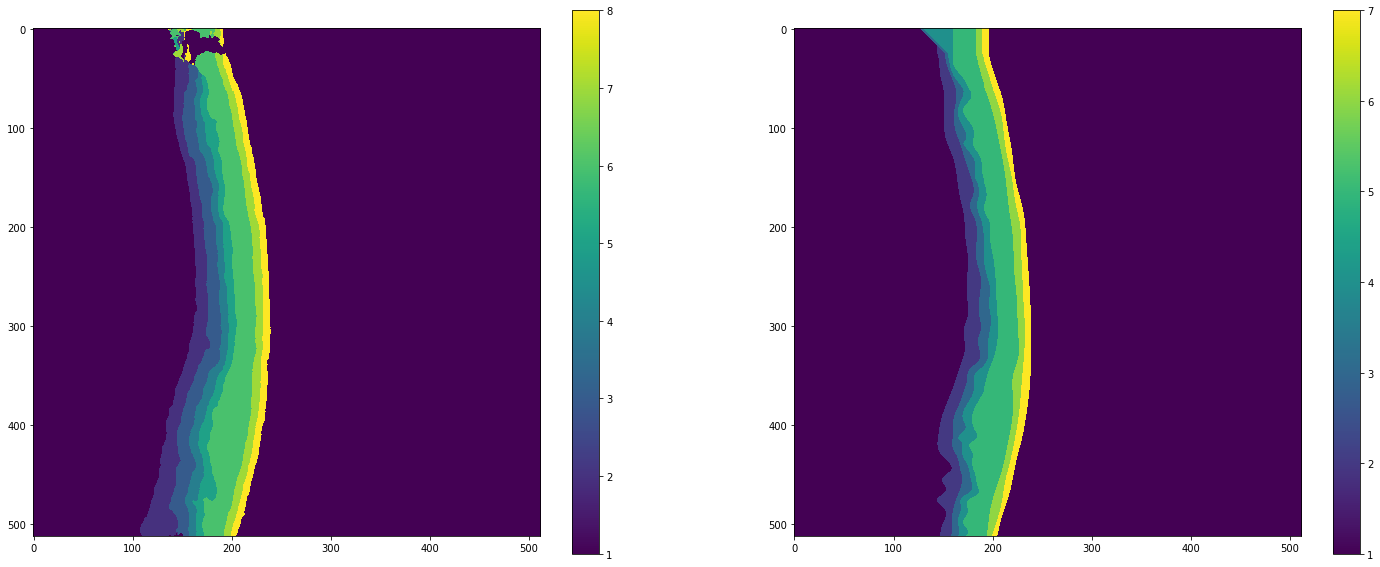

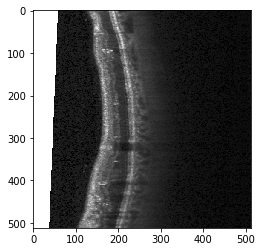

Image 12


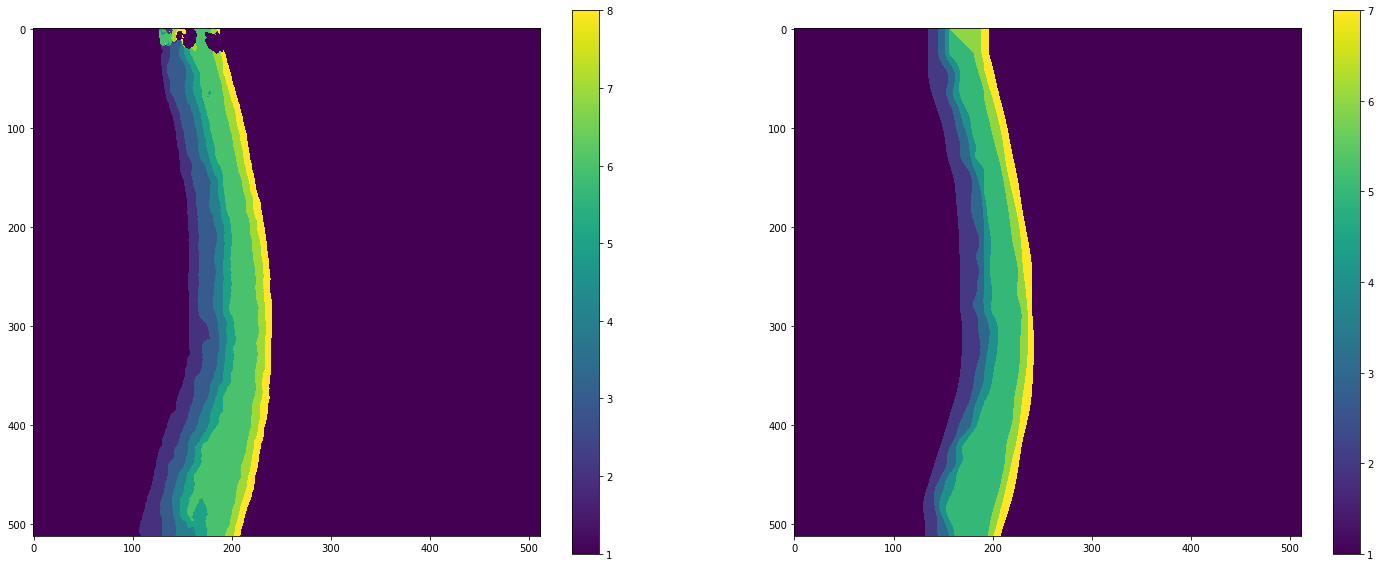

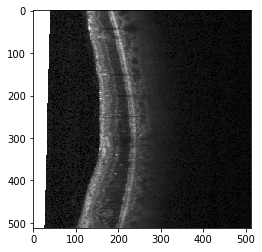

Image 13


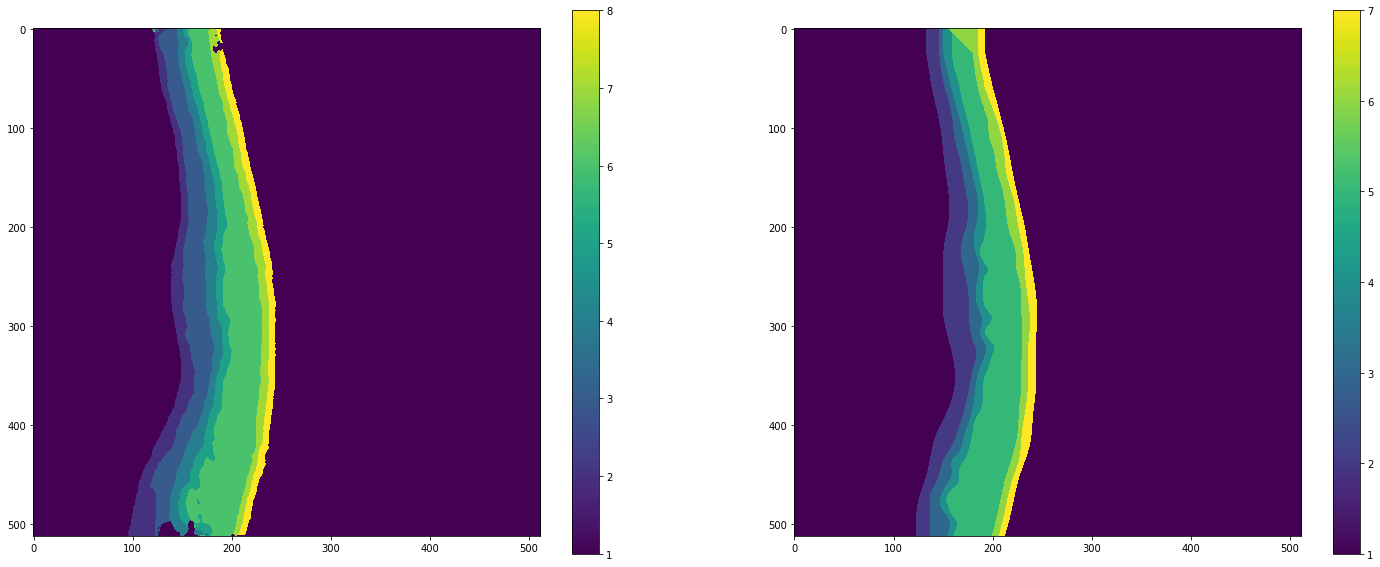

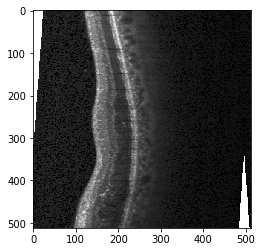

Image 14


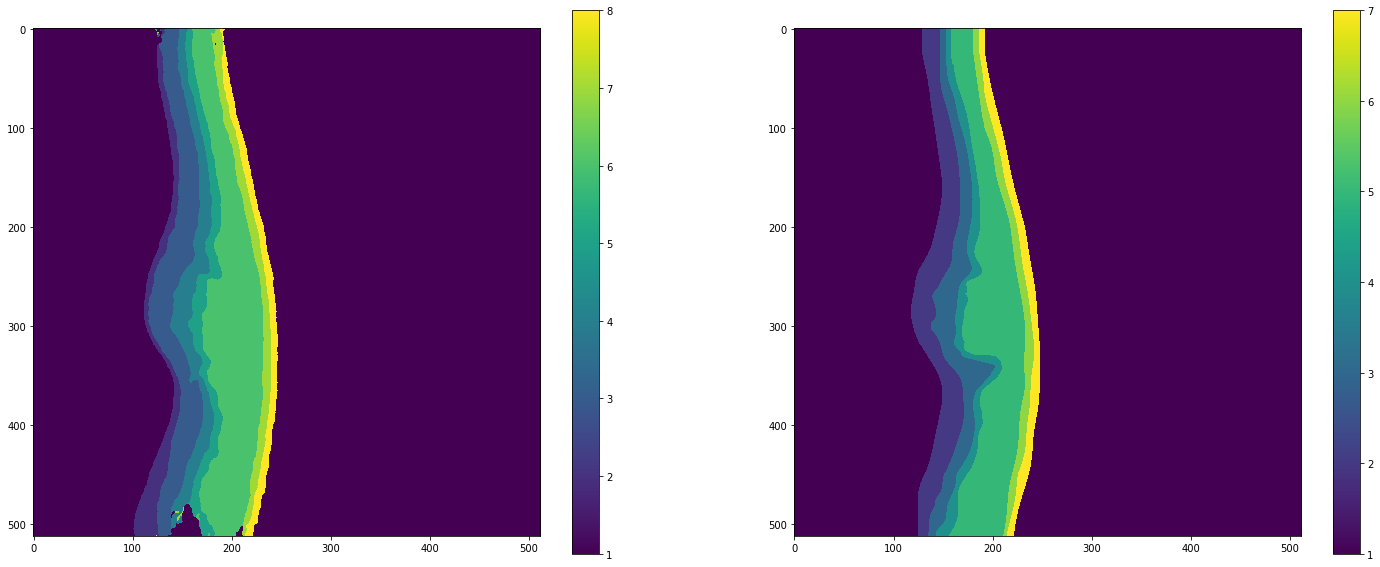

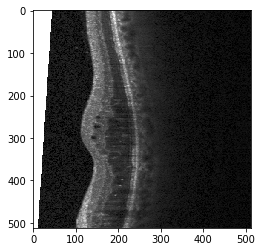

Image 15


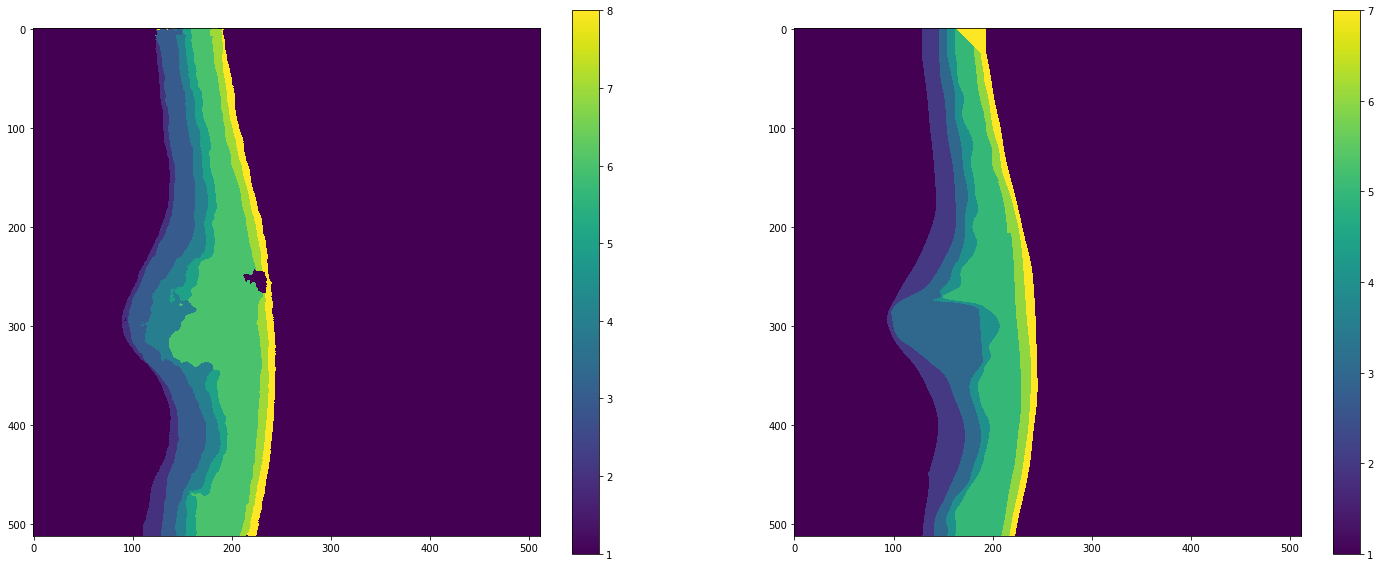

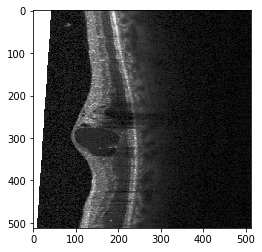

Image 16


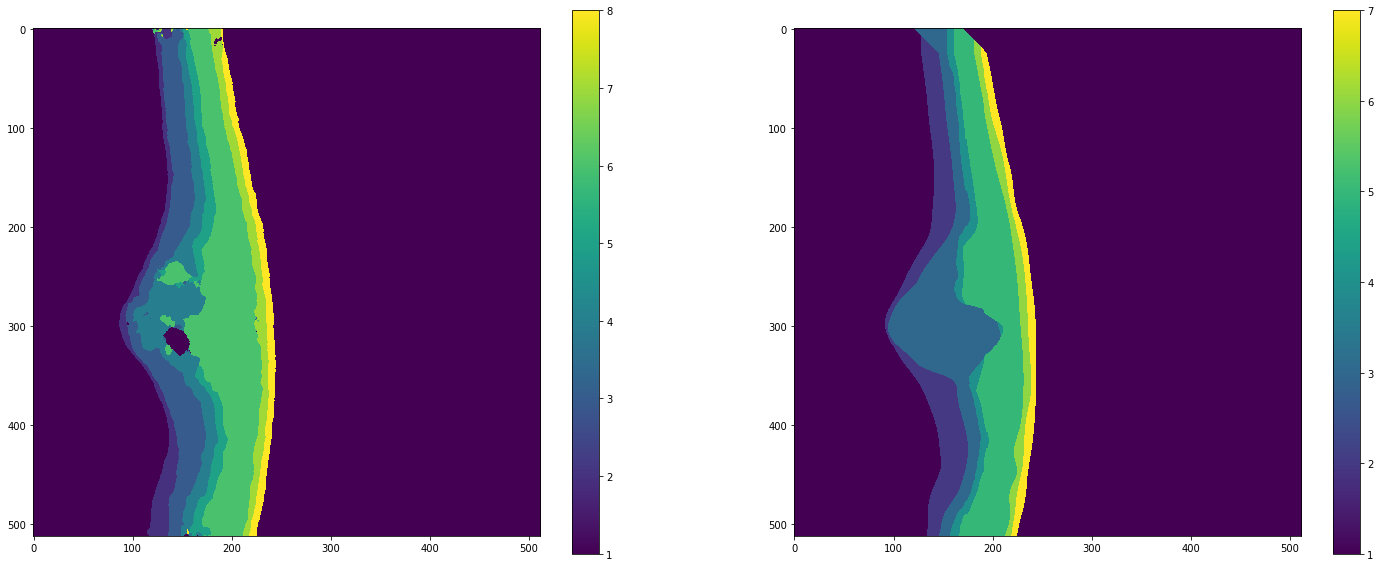

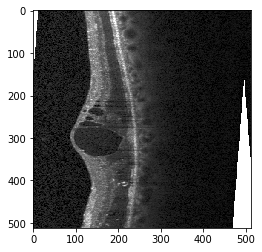

Image 17


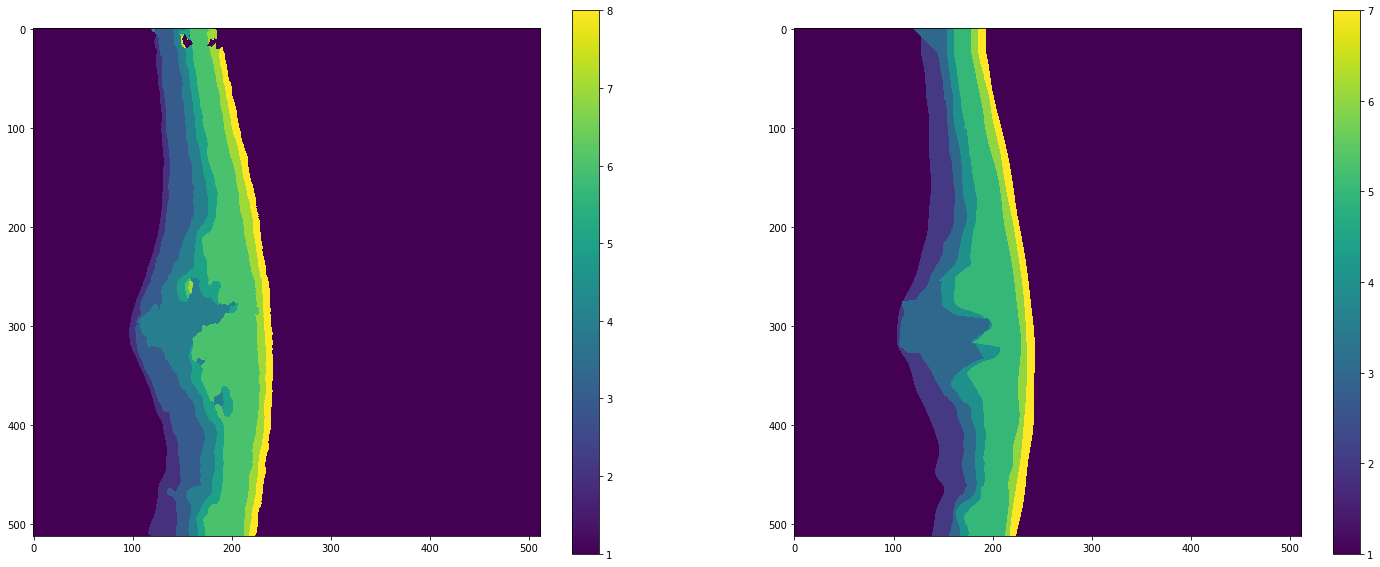

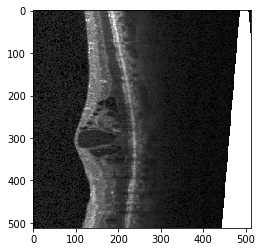

Image 18


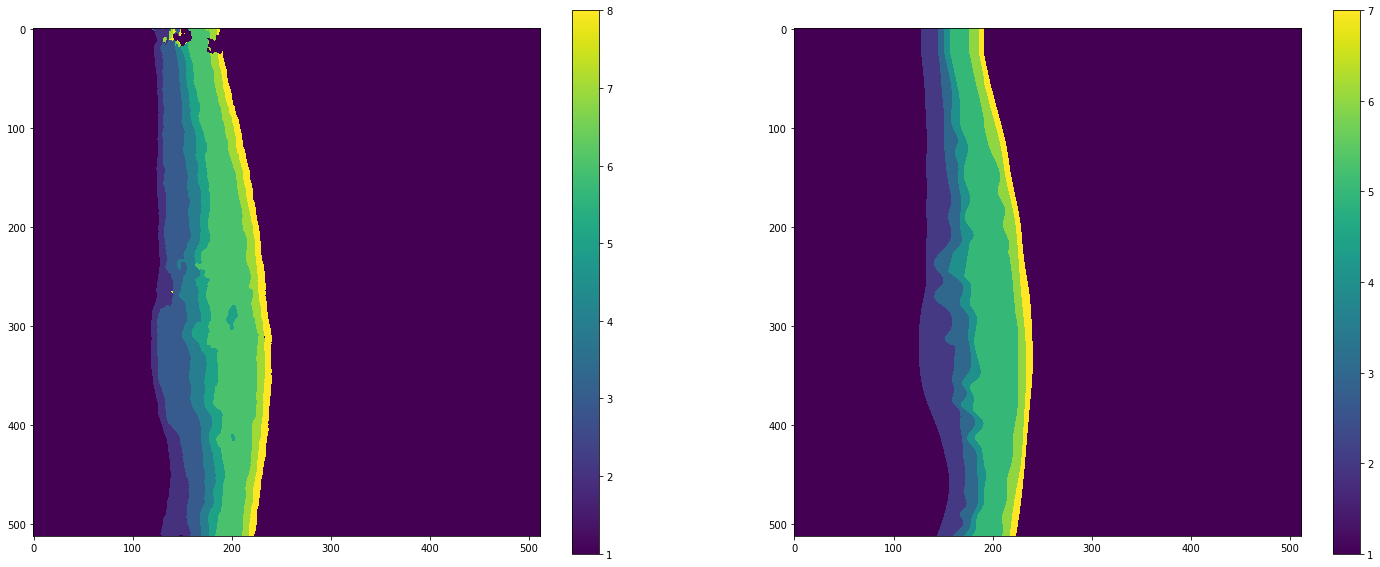

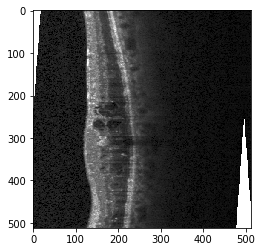

Image 19


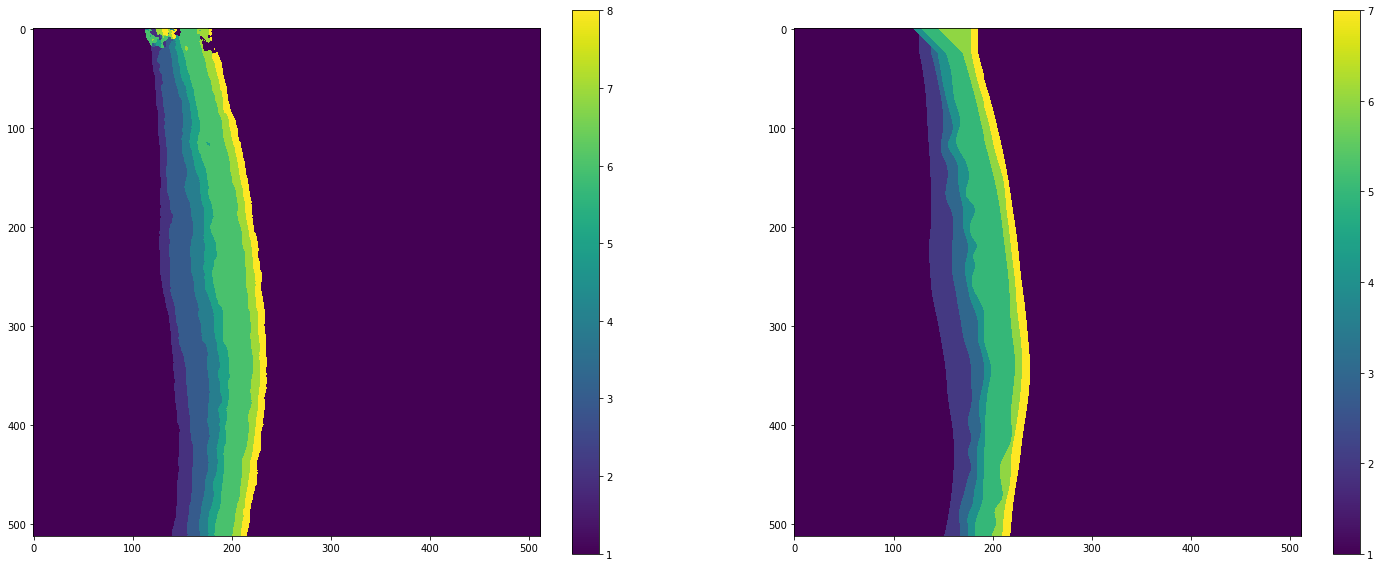

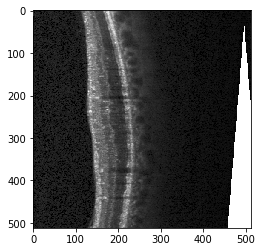

Image 20


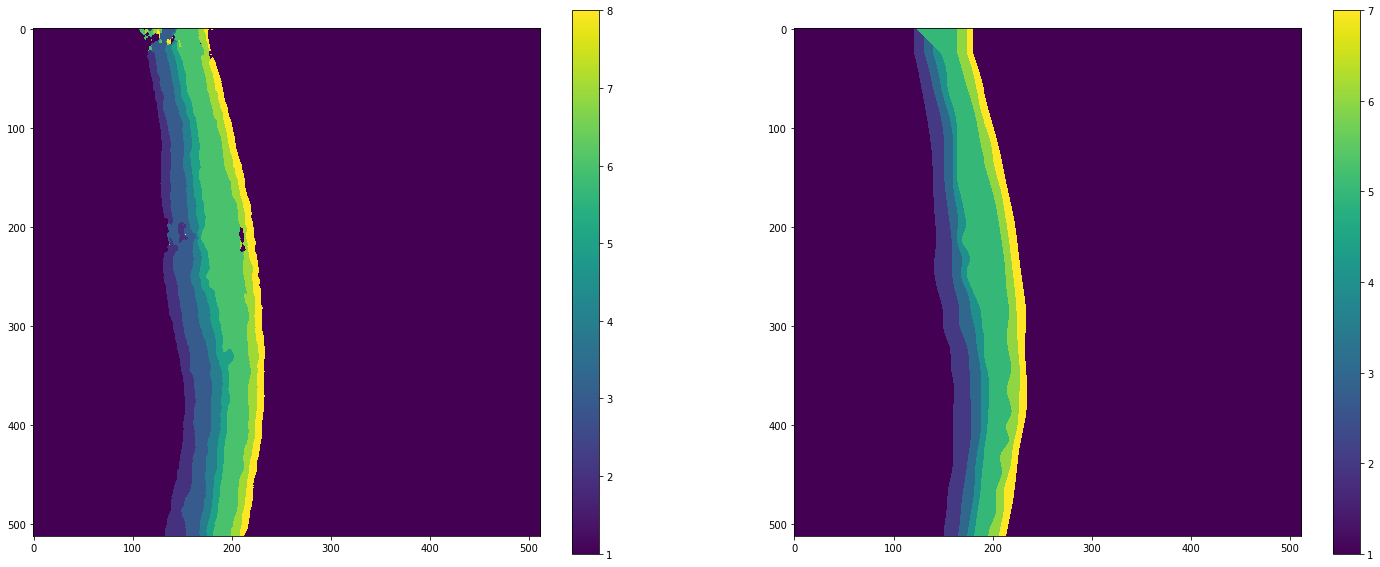

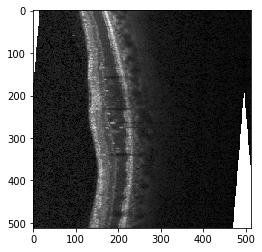

Image 21


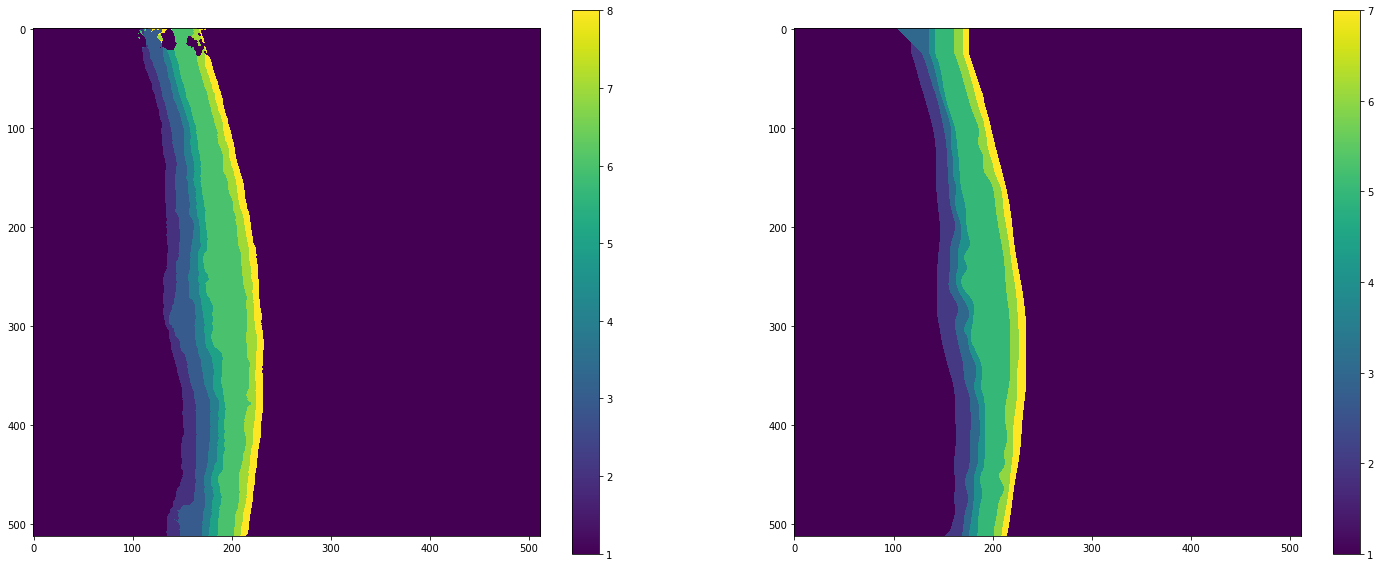

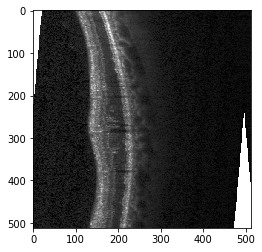

In [6]:
for i, img_test in enumerate(test_data.X):
    print('Image {}'.format(i))
    img_test = img_test[np.newaxis, :]
    out = relay_net(Variable(torch.Tensor(img_test).cuda(),volatile=True))
    idx = np.argmax(out.data, 1).squeeze()

    plt.figure(figsize=(25,10))
    plt.subplot(121)
    plt.imshow(idx)
    plt.colorbar()

    plt.subplot(122)
    y = test_data.y[i:i+1].astype(np.int)
    y[y == 9] = 1
    y -= 1
    y[y == 0] = 1
    y[y == -1] = 0
    y = np.squeeze(y)
    plt.imshow(y)
    plt.colorbar()
    plt.show()


    img_test = test_data.X[i:i+1]
    img_test = np.squeeze(img_test)
    plt.imshow(img_test, cmap='gray')
    plt.show()

In [7]:

del out, idx, relay_net

In [4]:
# Best model with epoch 33 and dice 0.7842397147958929

relay_net = RelayNet(dropout_prob=0.5, basic_block=DenseBlock)
relay_net.load_state_dict(torch.load('models_dense_dropout/model-33.model'))
relay_net = relay_net.cuda()
relay_net.eval()

In [9]:
valid(test_data, relay_net, args(batch_size=4, cuda=True), mc_samples=30)

100%|██████████| 11/11 [01:29<00:00,  8.18s/it]

Validation dice avg: 0.7844437956809998


0.7844437956809998

In [7]:
error_map_dice(test_data, relay_net, args(batch_size=2, cuda=True))

100%|██████████| 11/11 [00:29<00:00,  2.72s/it]

dice avg: 0.43842902508648957


0.43842902508648957

/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Image 0
False


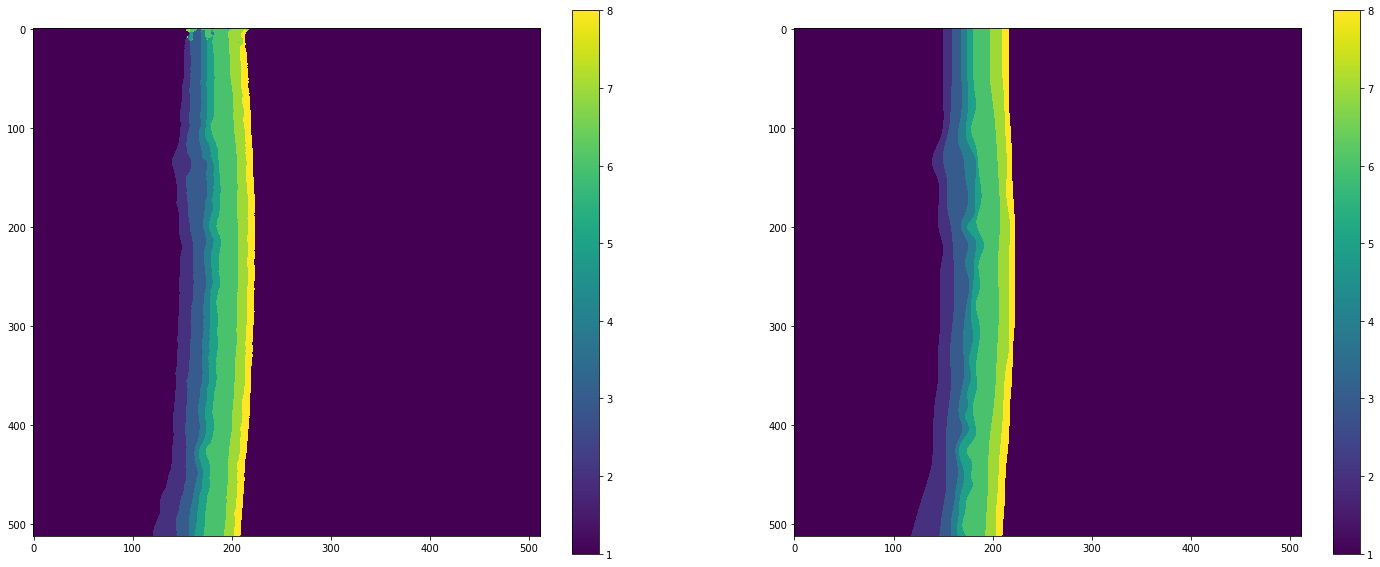

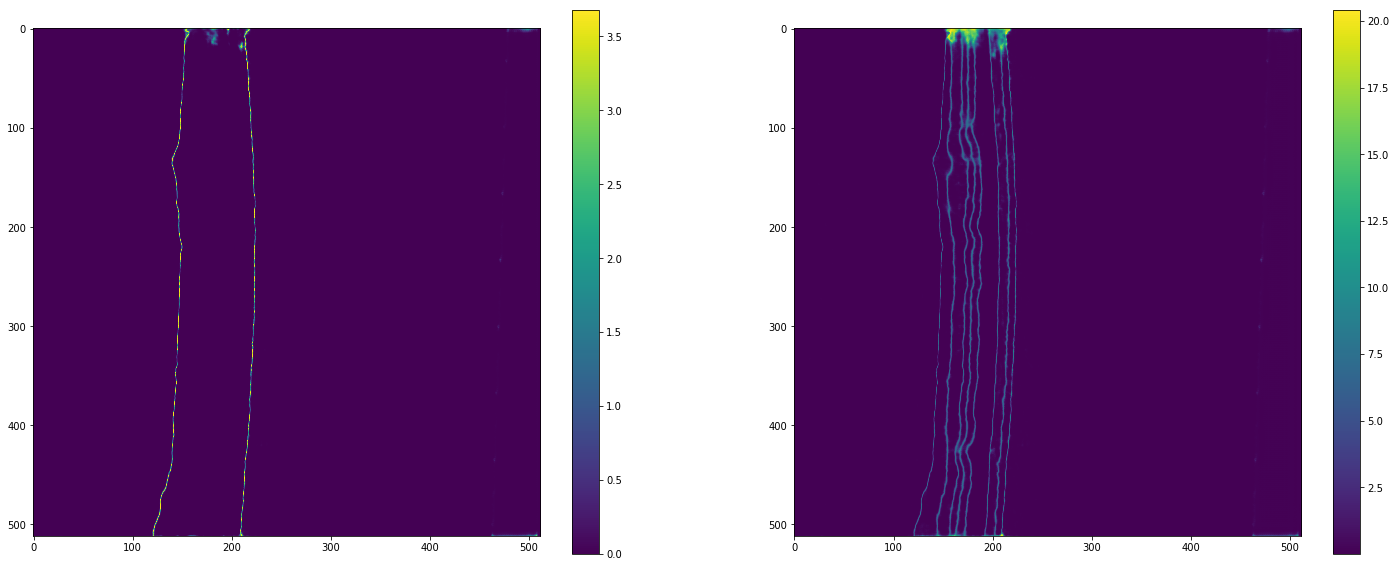

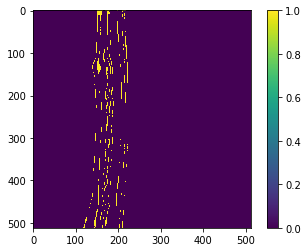

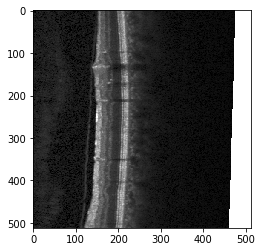

Image 1
False


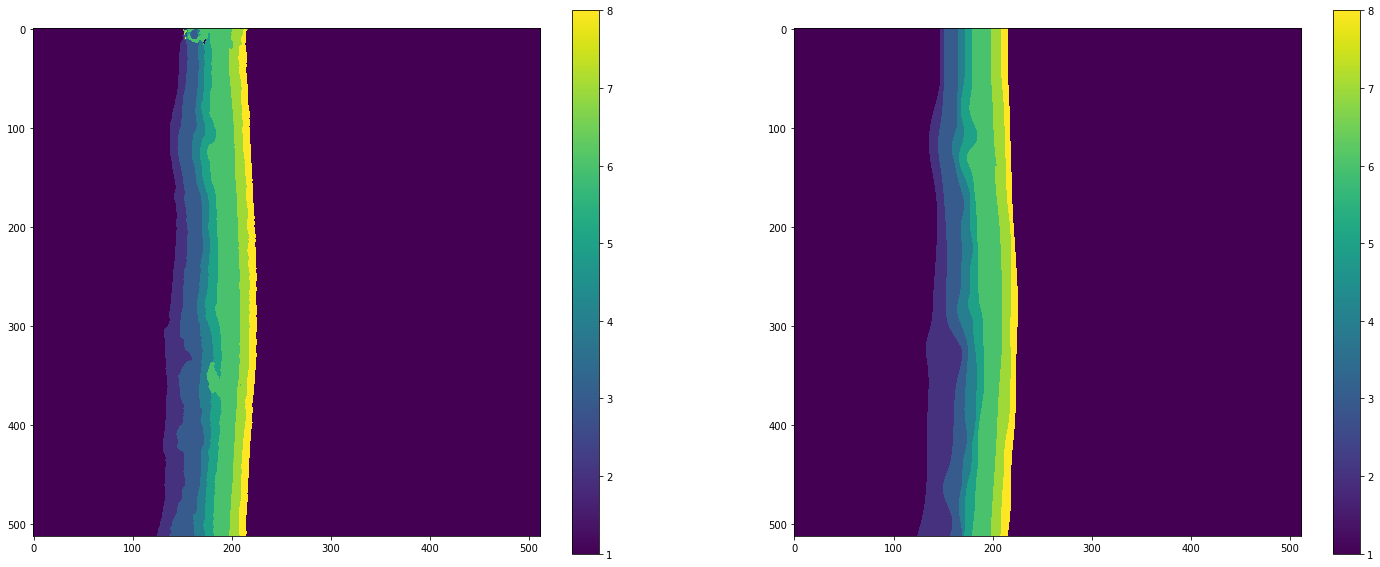

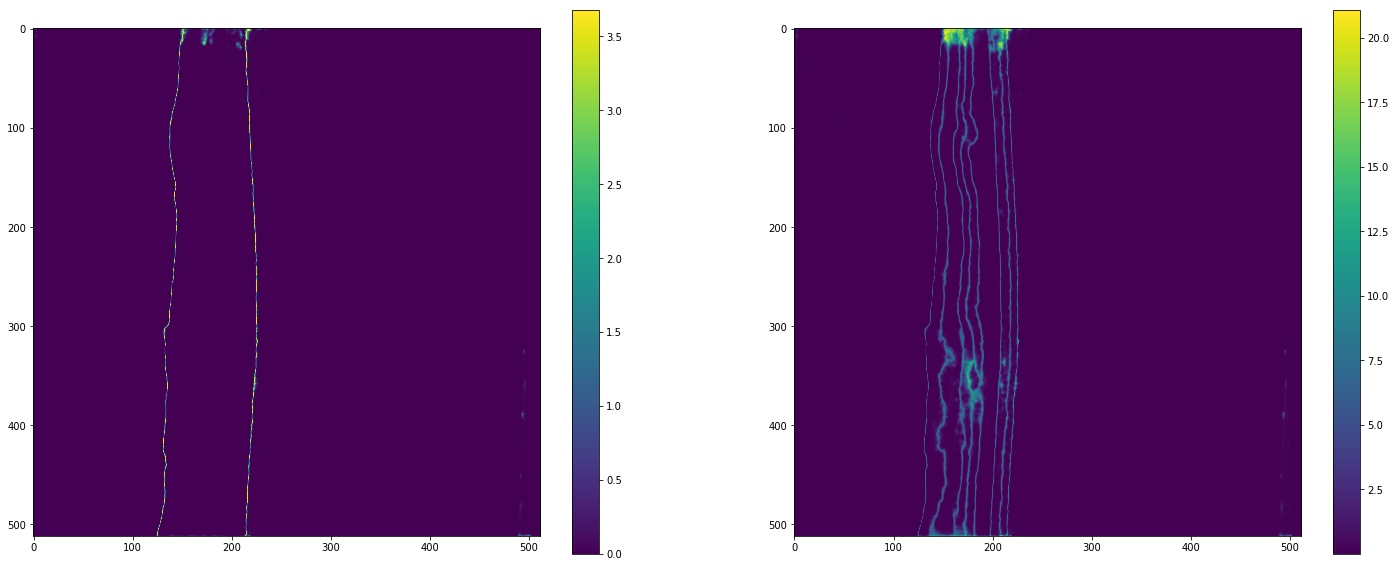

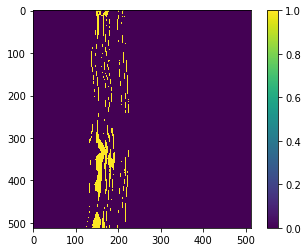

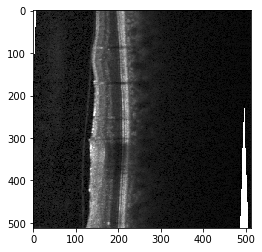

Image 2
False


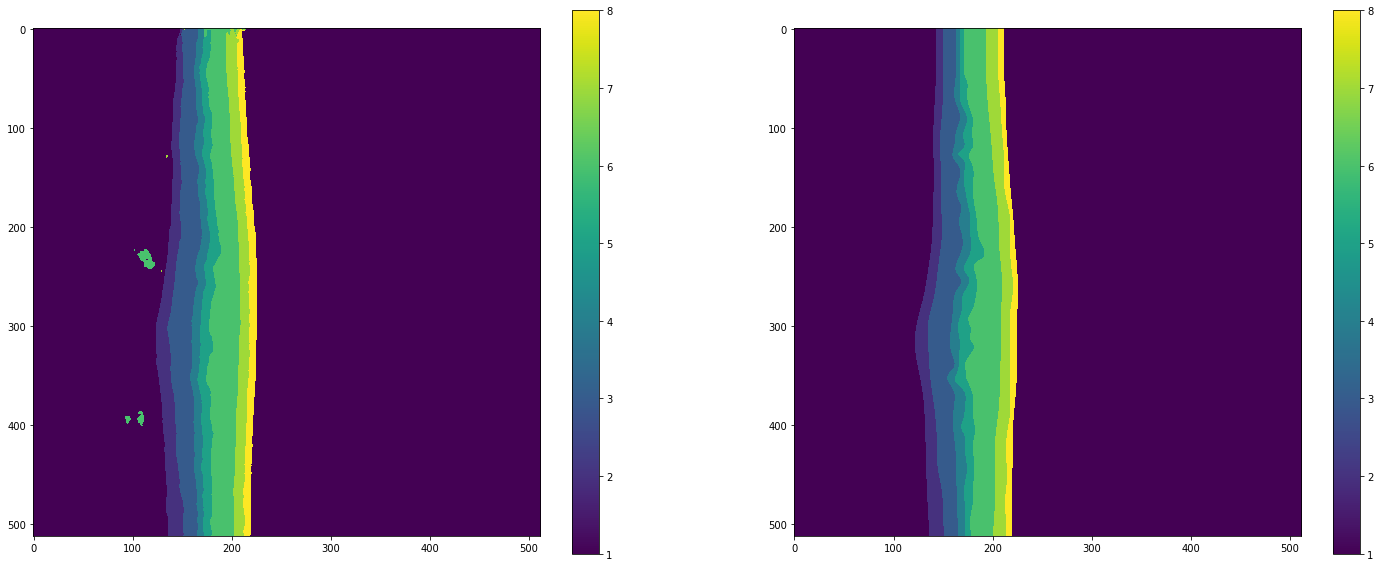

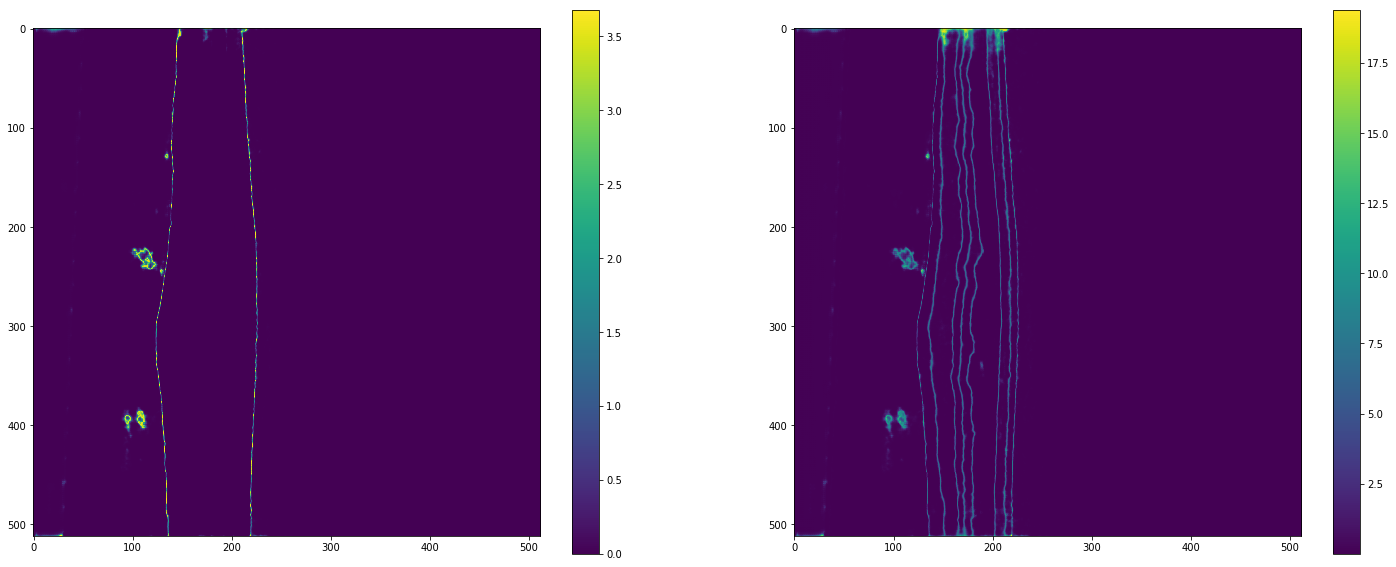

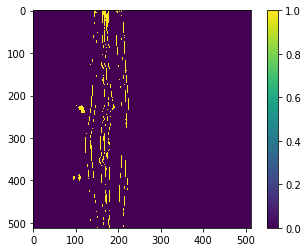

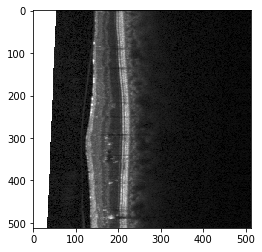

Image 3
False


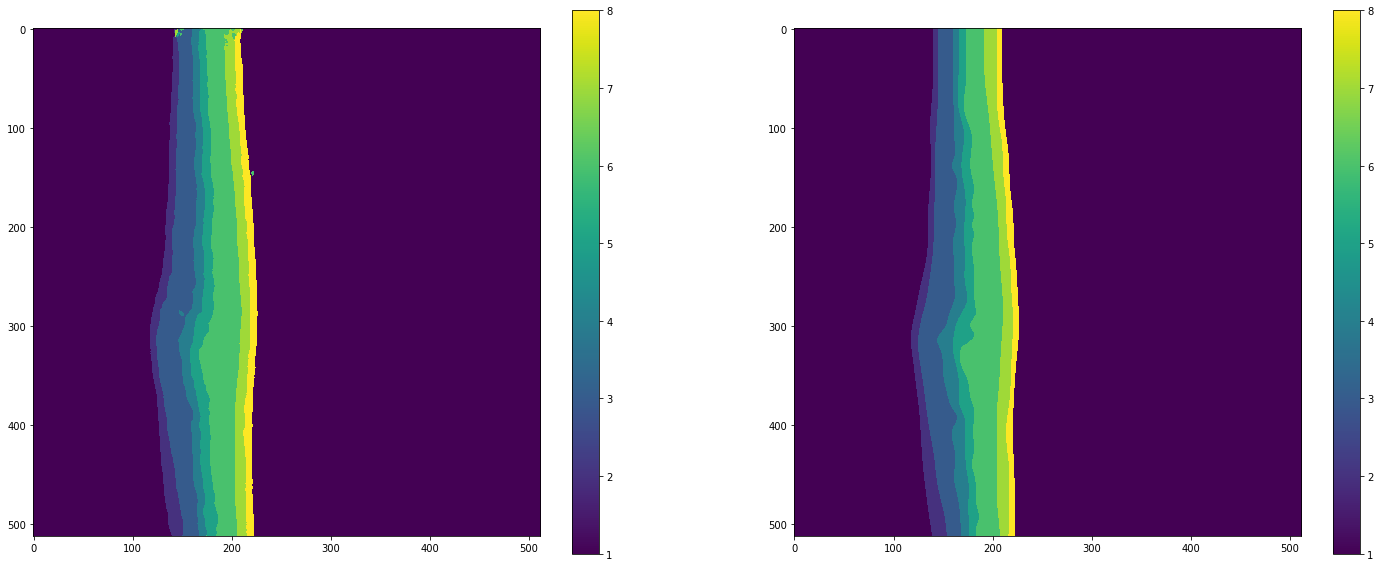

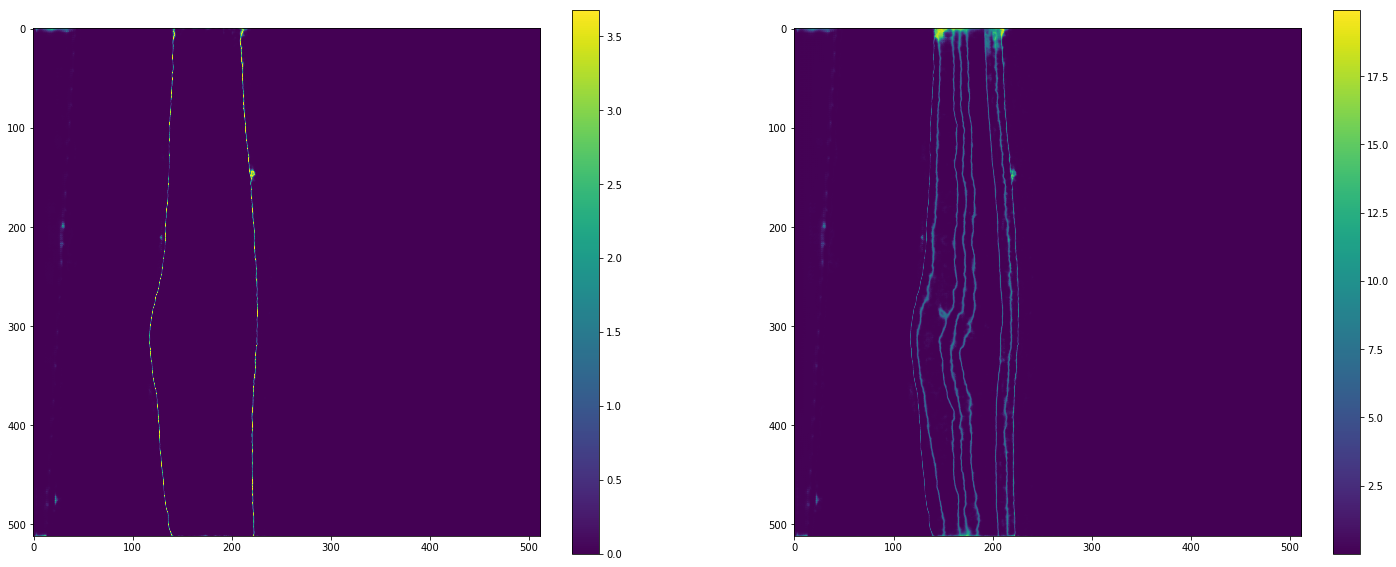

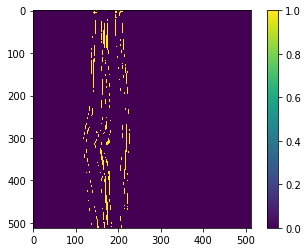

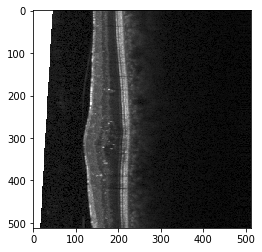

Image 4
False


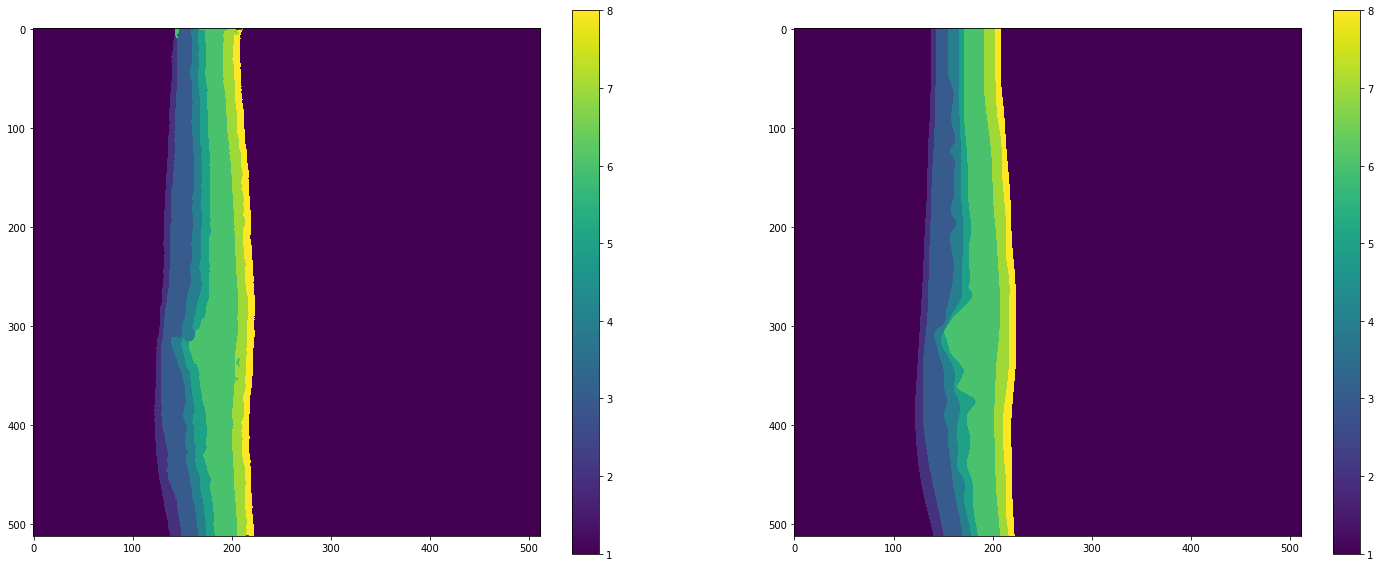

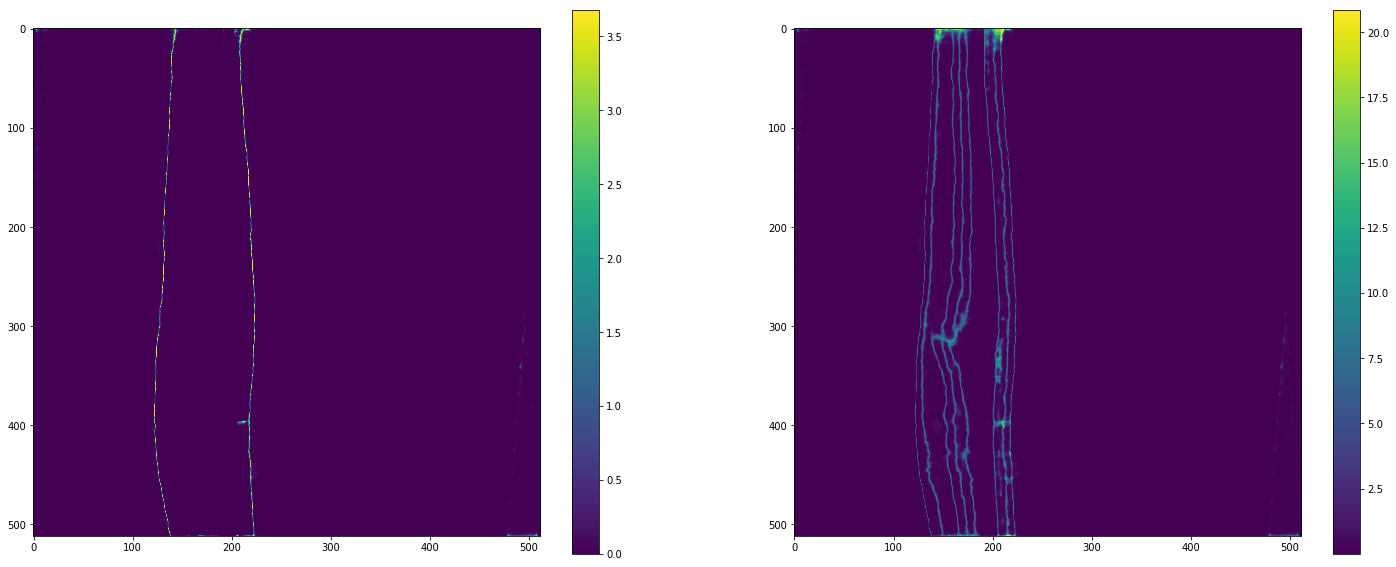

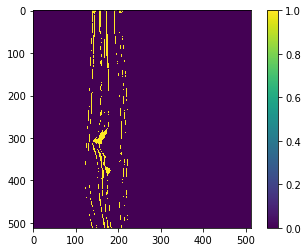

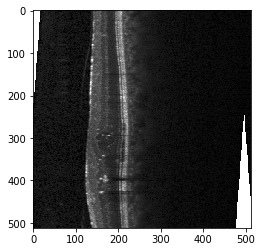

Image 5
False


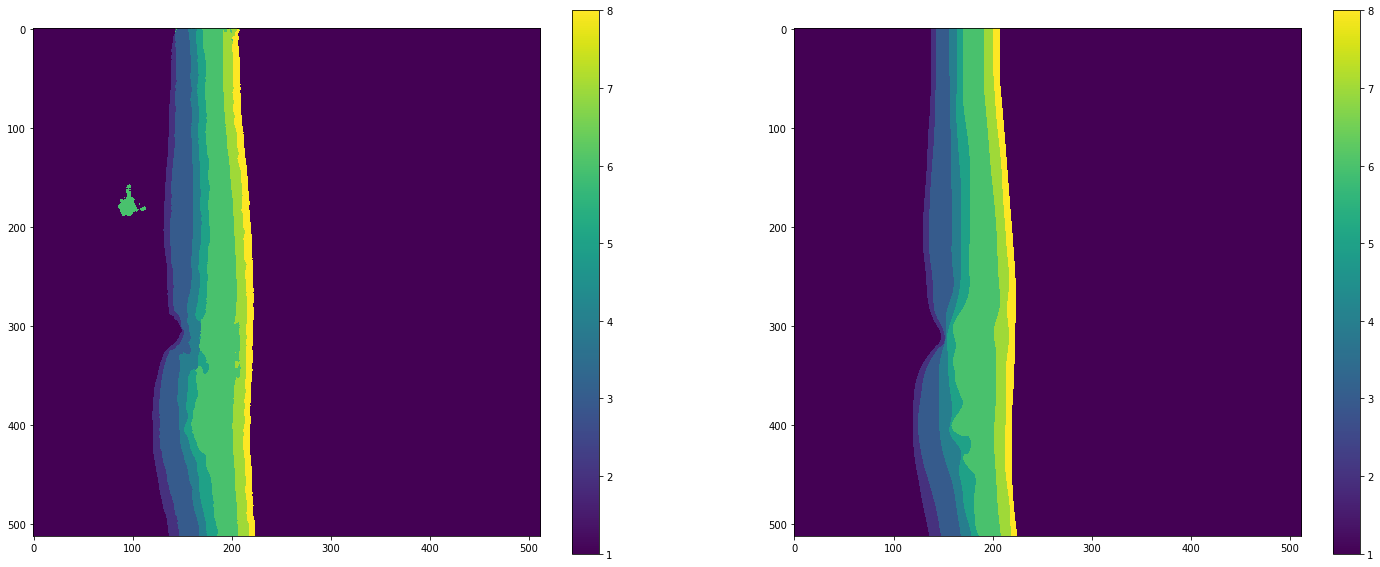

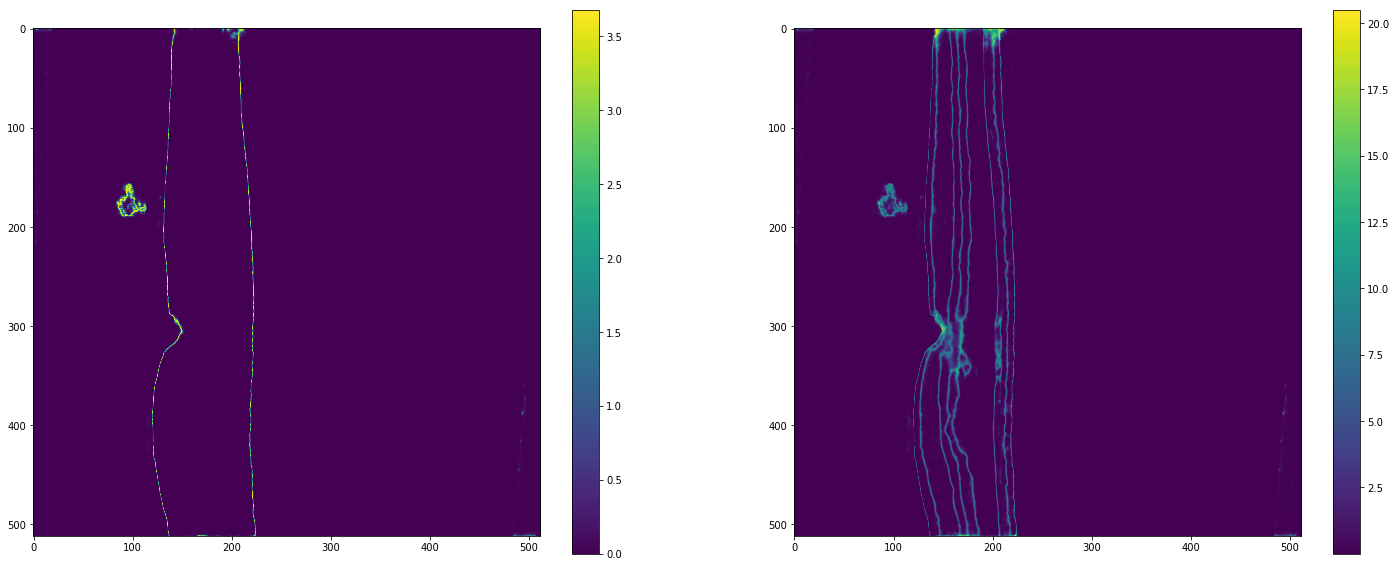

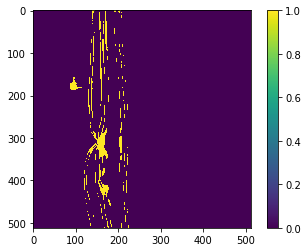

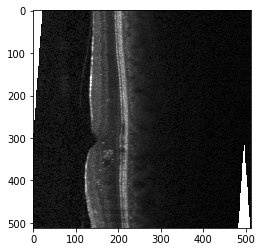

Image 6
False


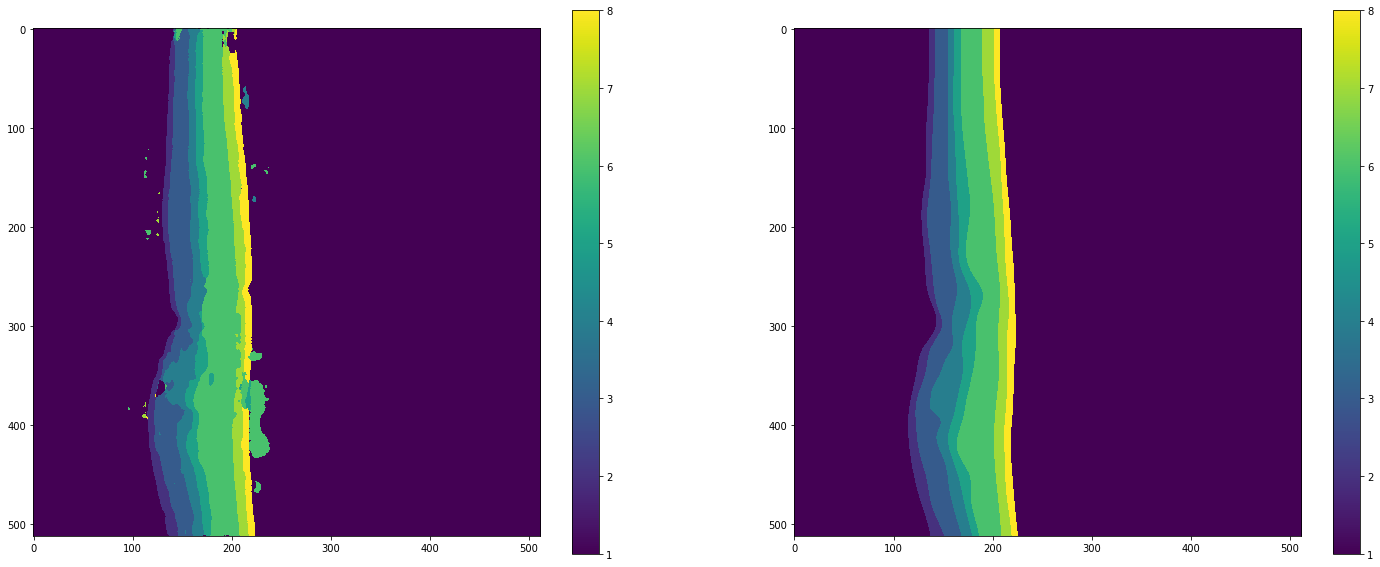

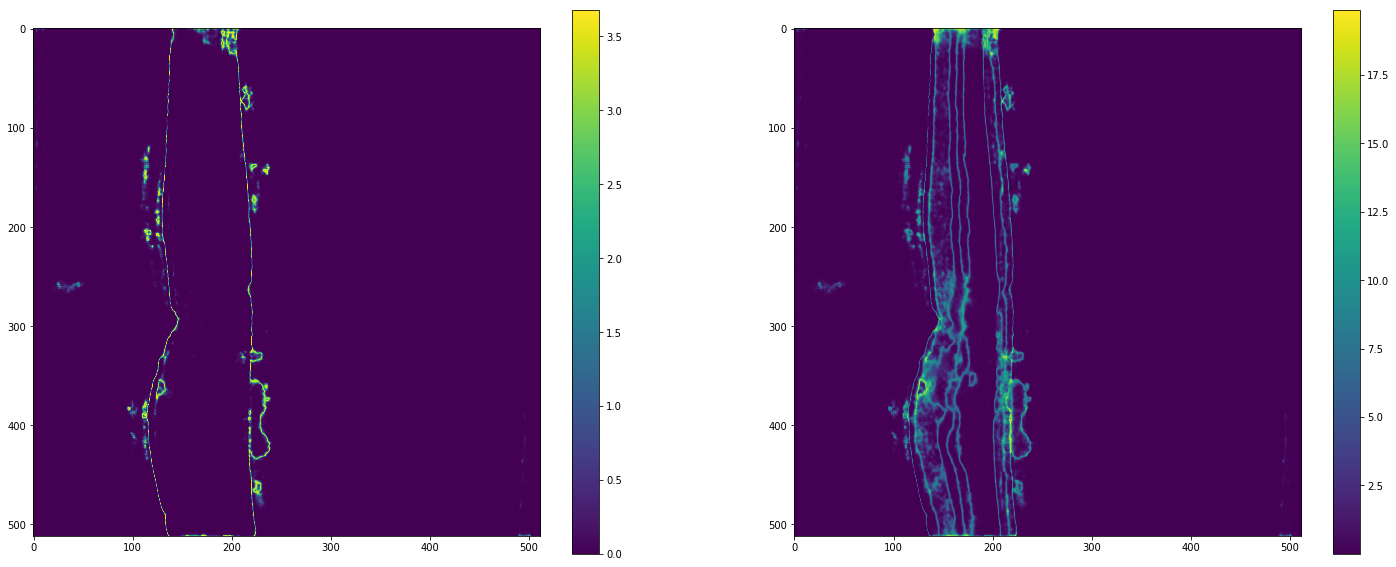

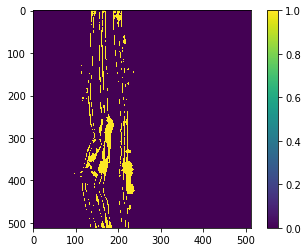

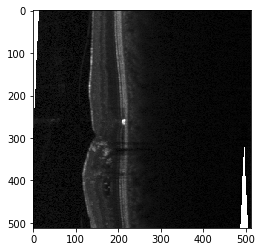

Image 7
False


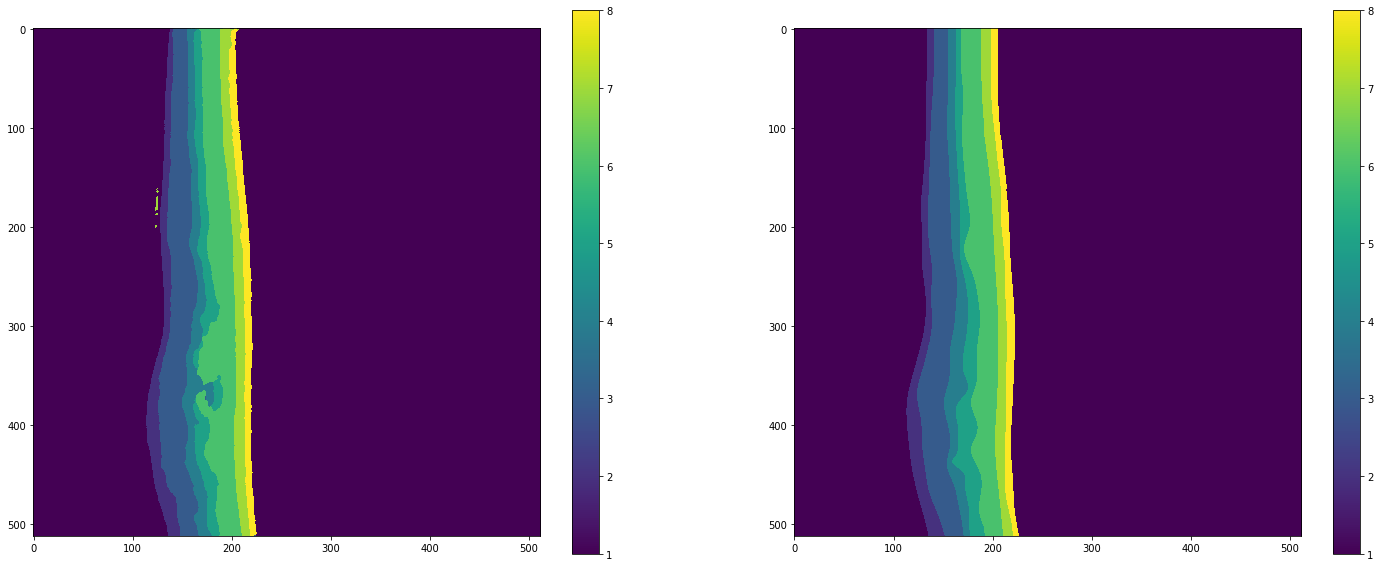

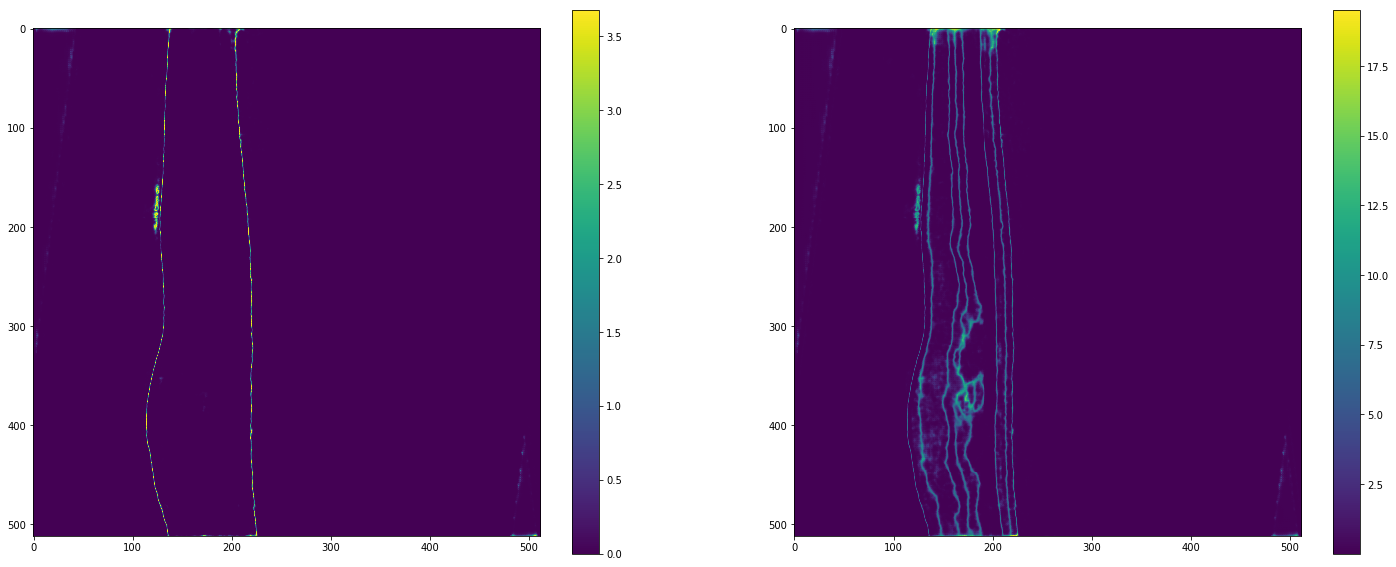

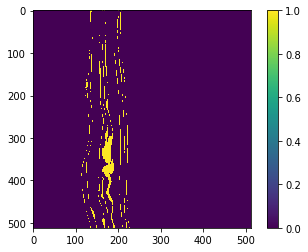

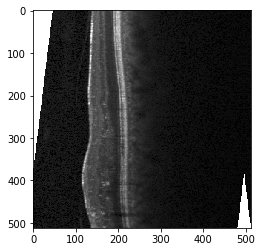

Image 8
False


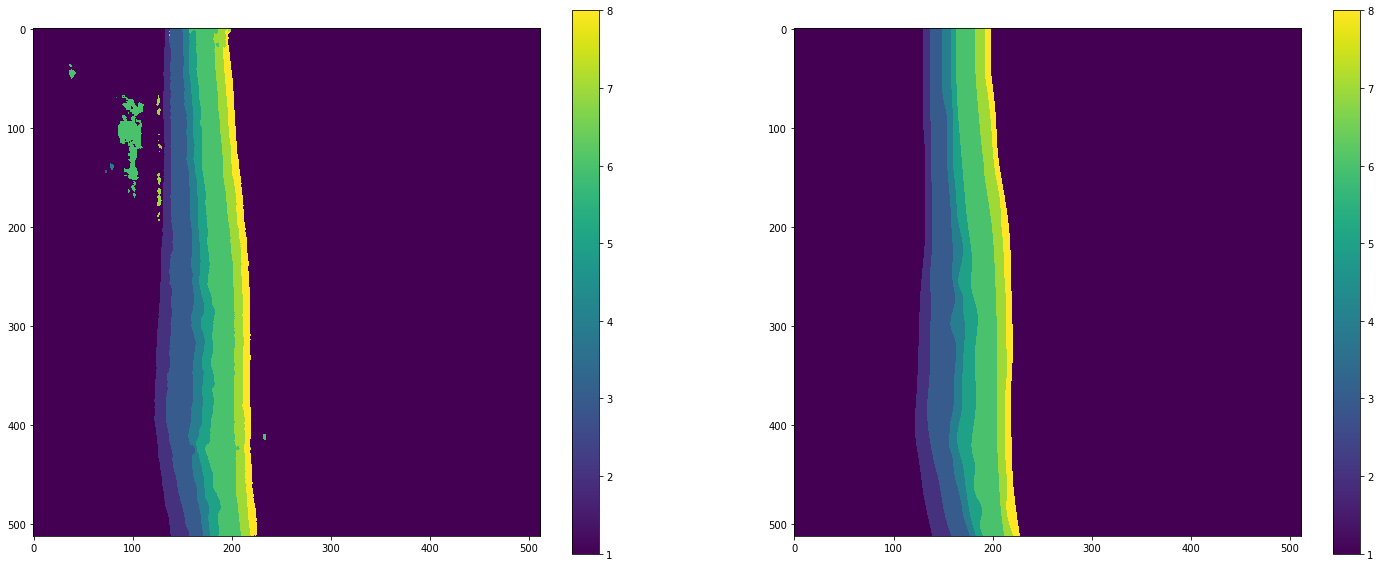

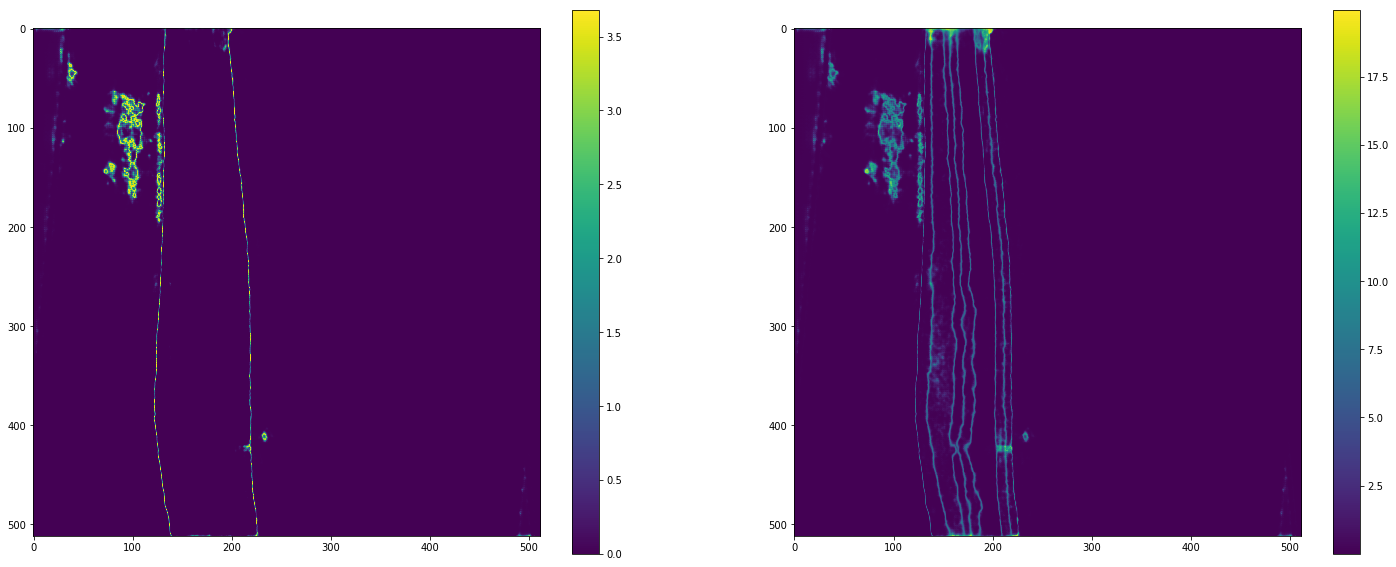

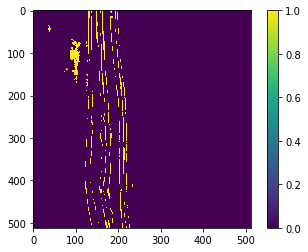

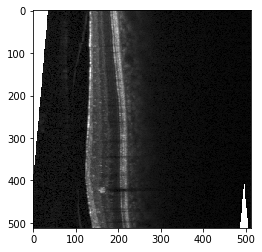

Image 9
False


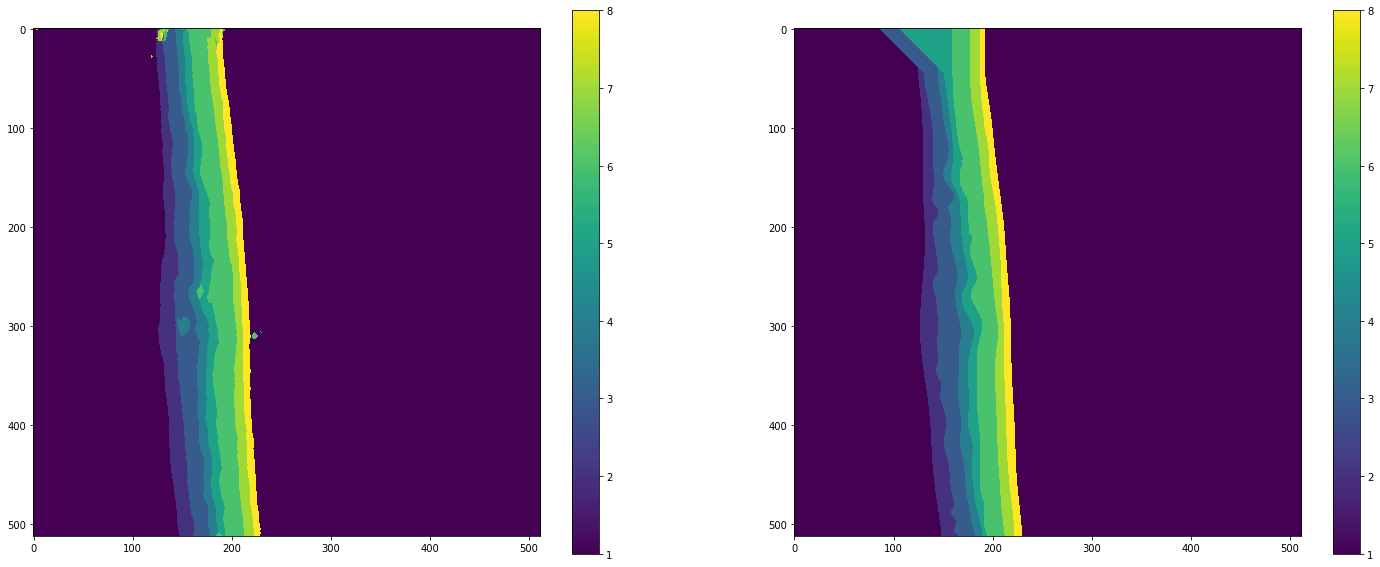

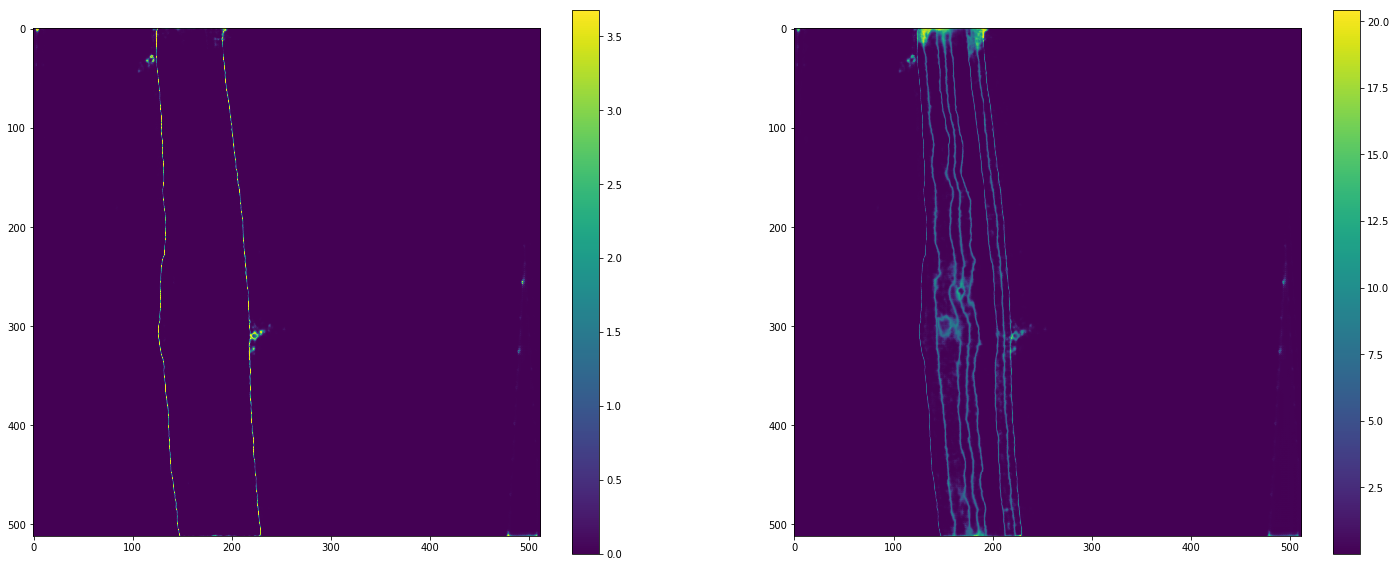

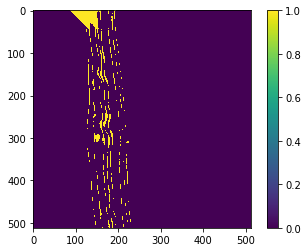

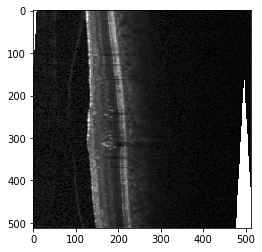

Image 10
False


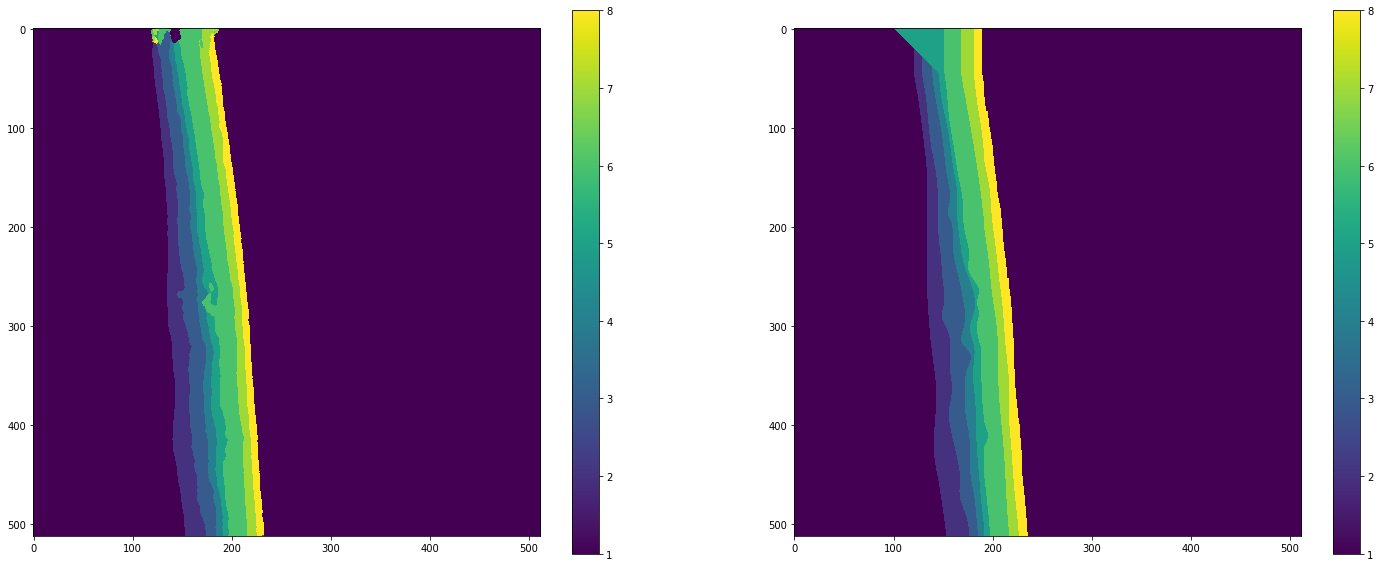

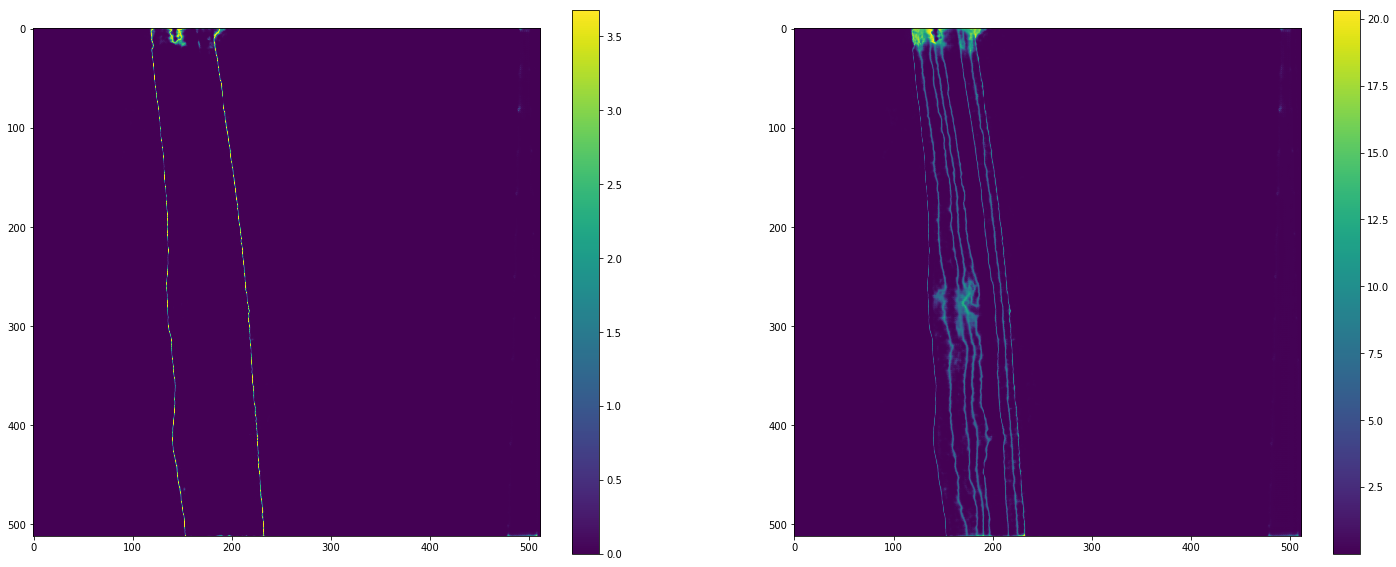

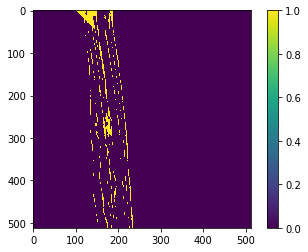

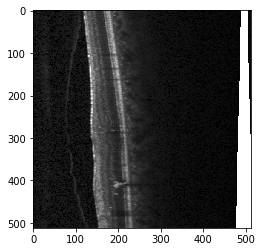

Image 11
False


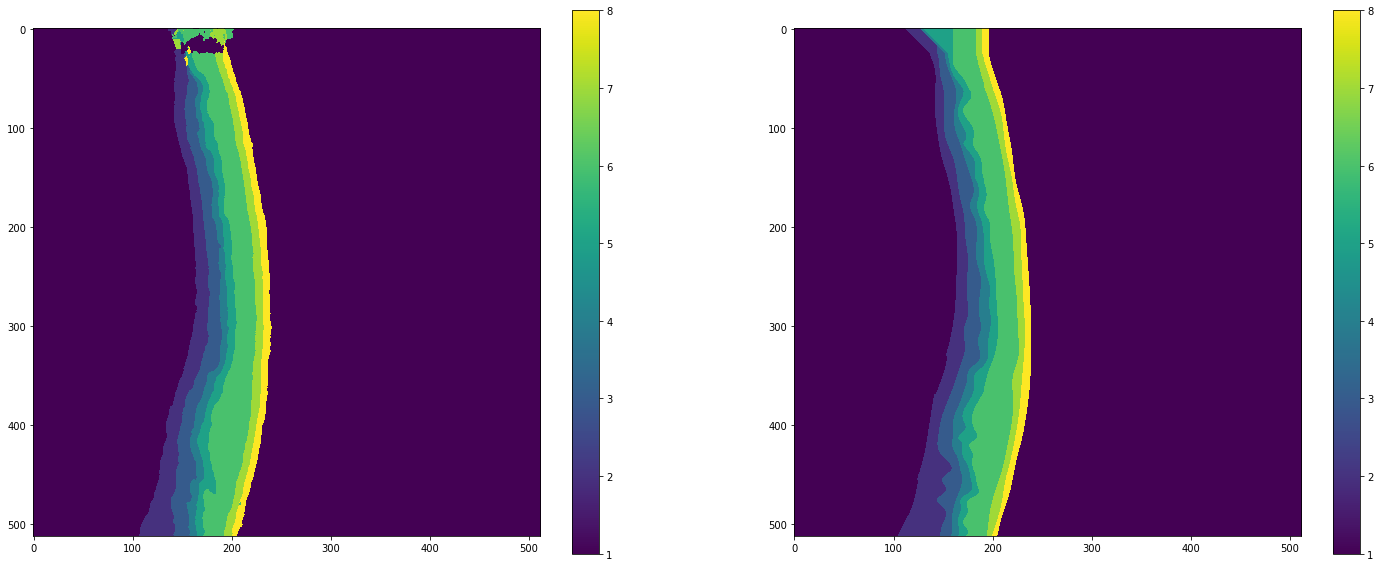

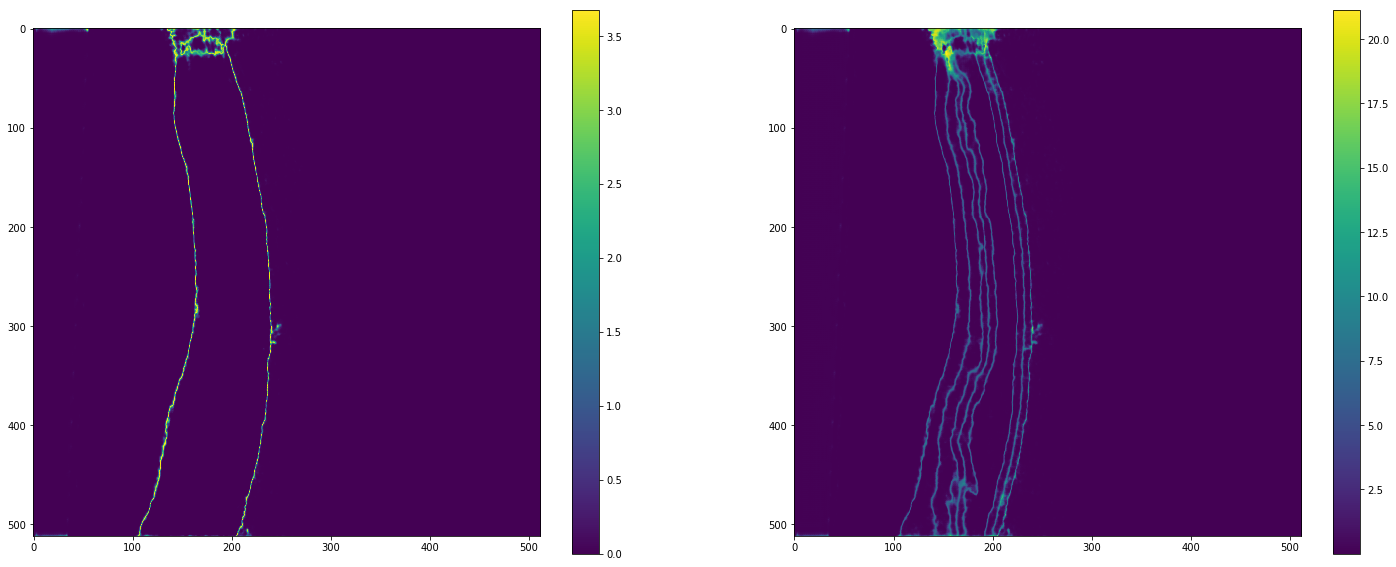

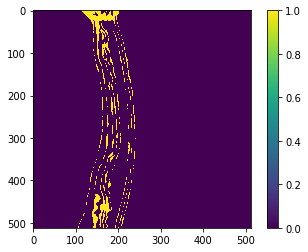

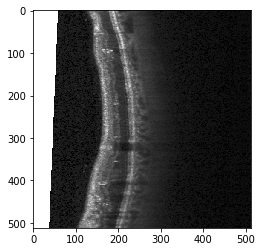

Image 12
False


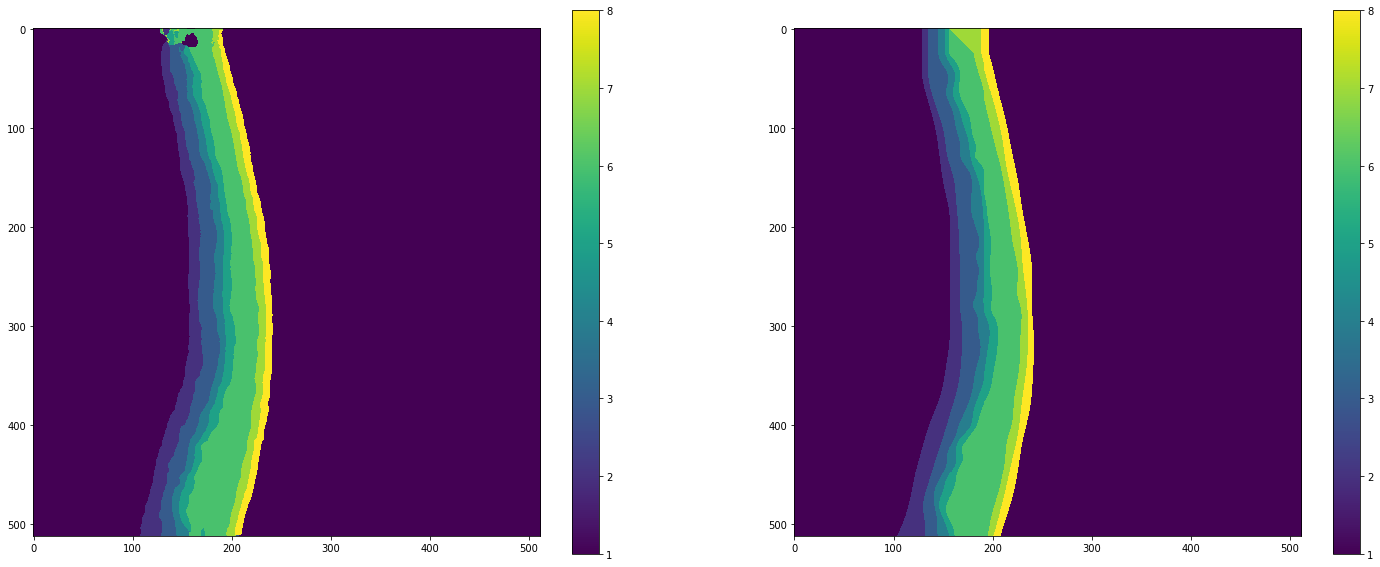

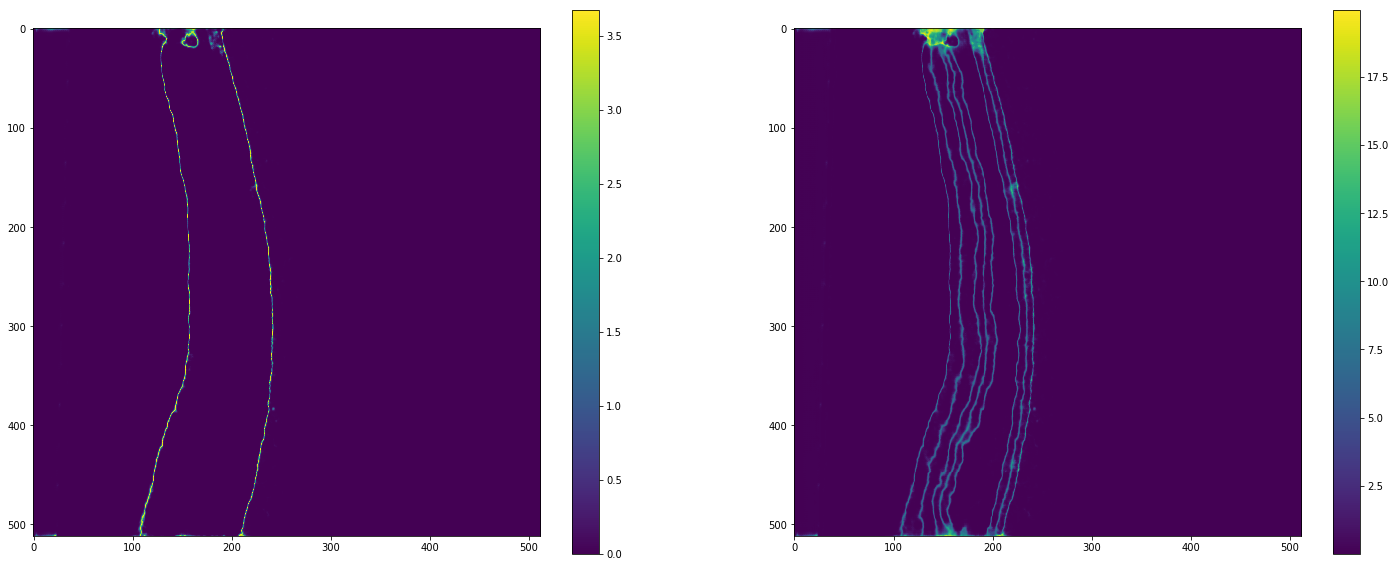

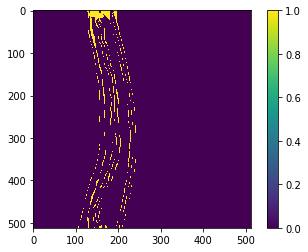

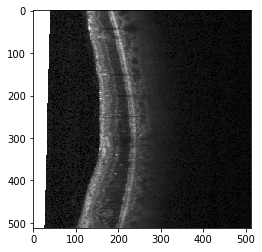

Image 13
False


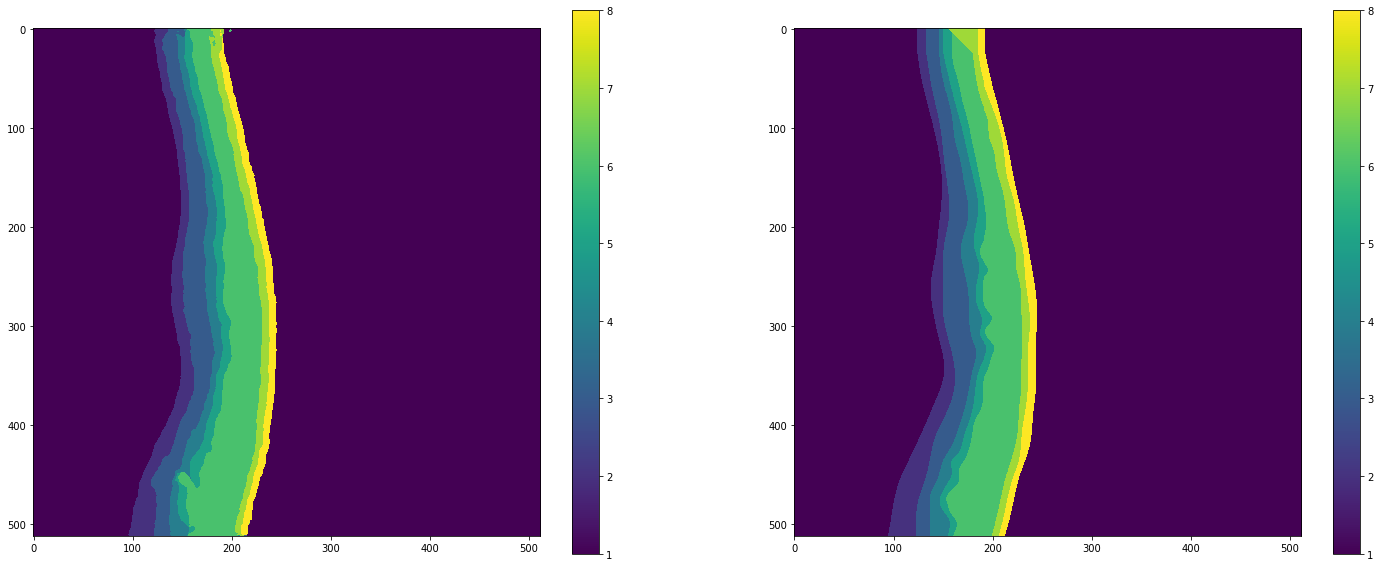

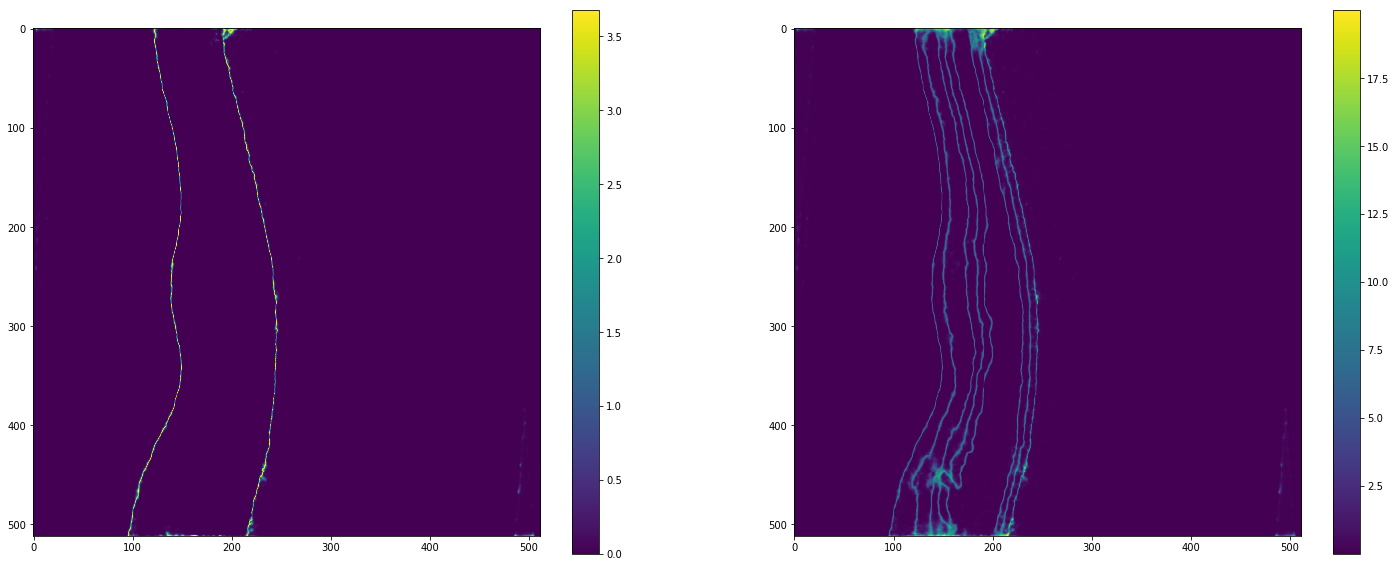

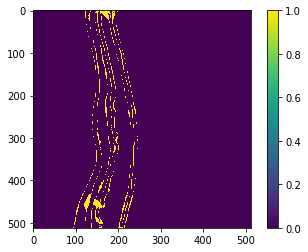

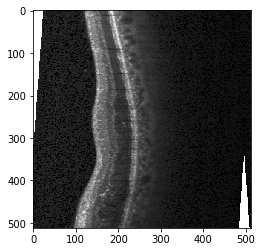

Image 14
False


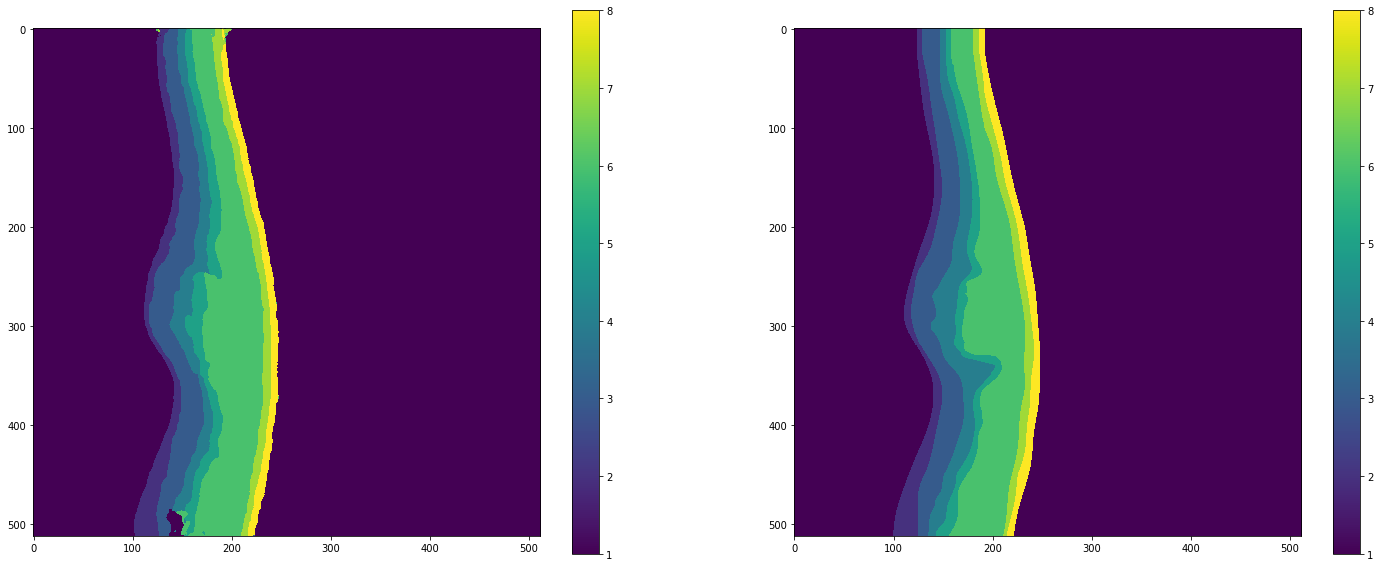

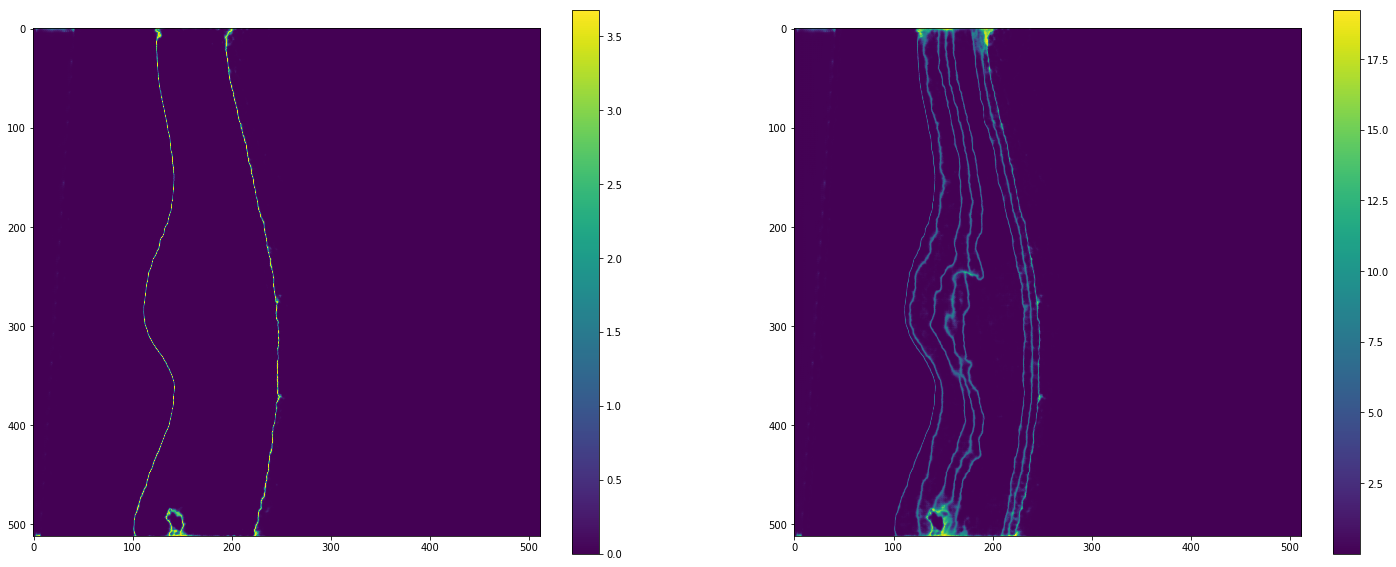

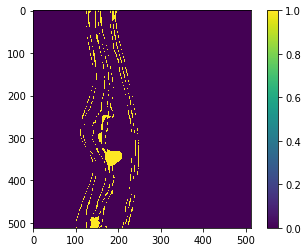

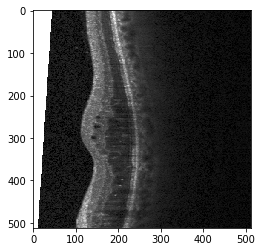

Image 15
False


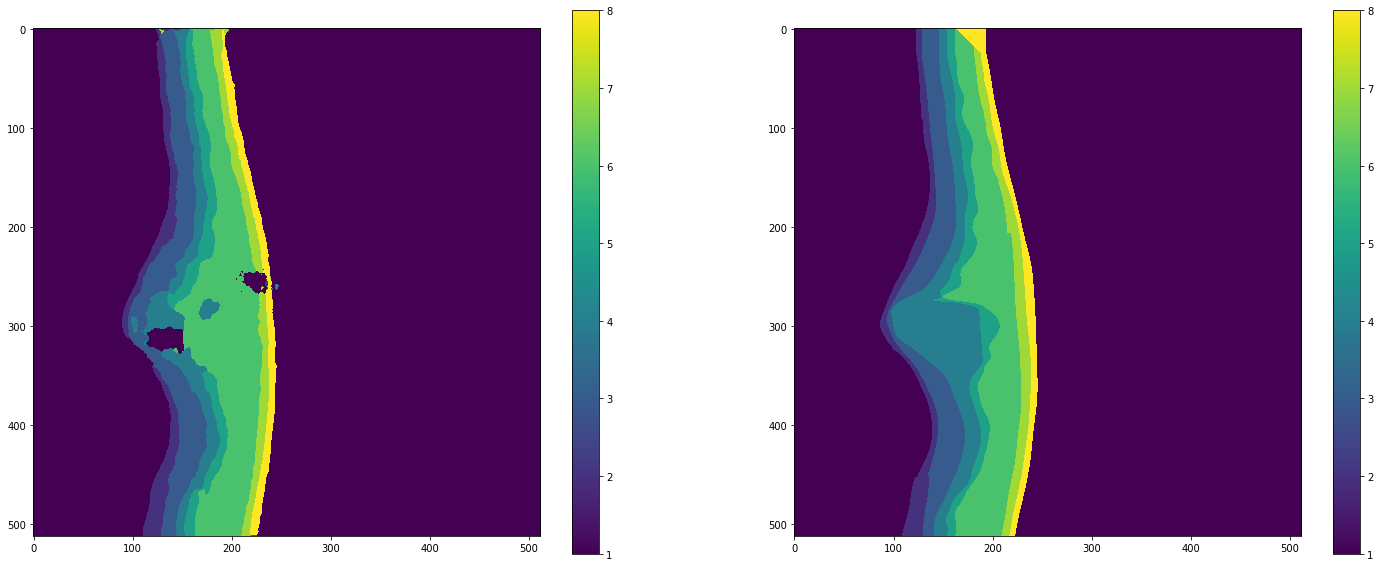

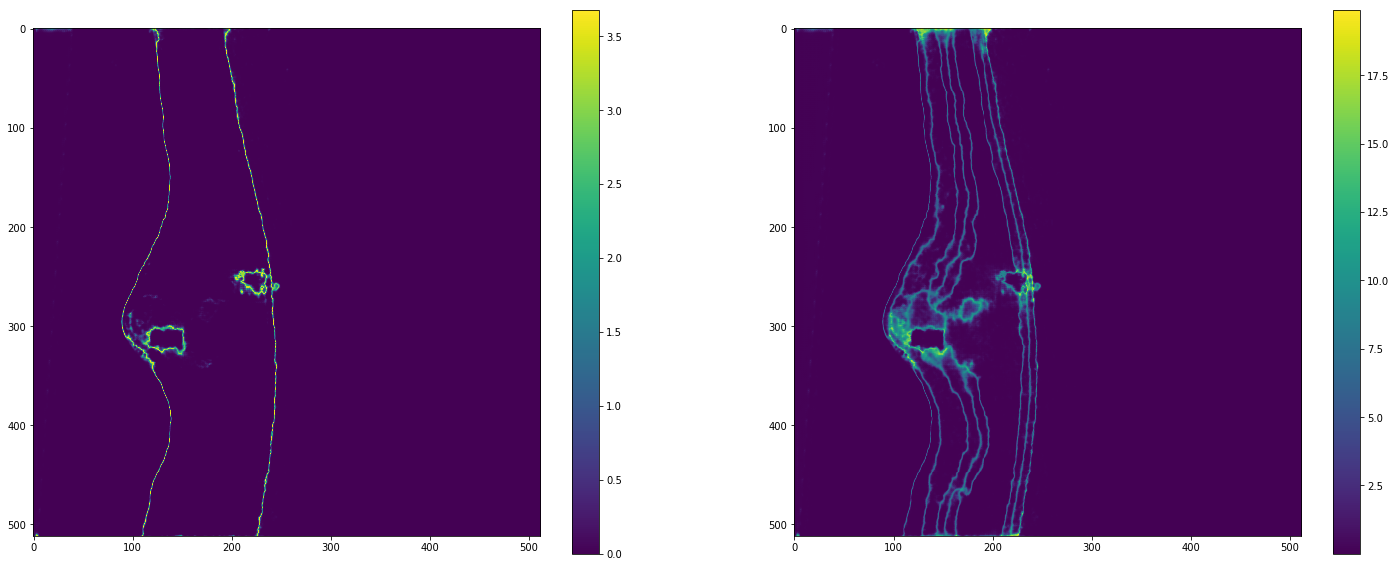

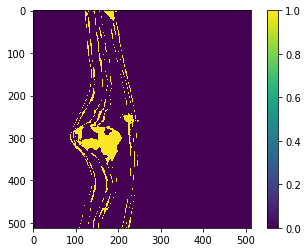

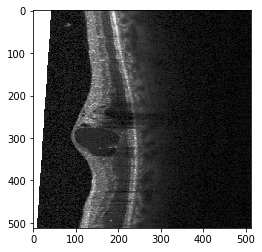

Image 16
False


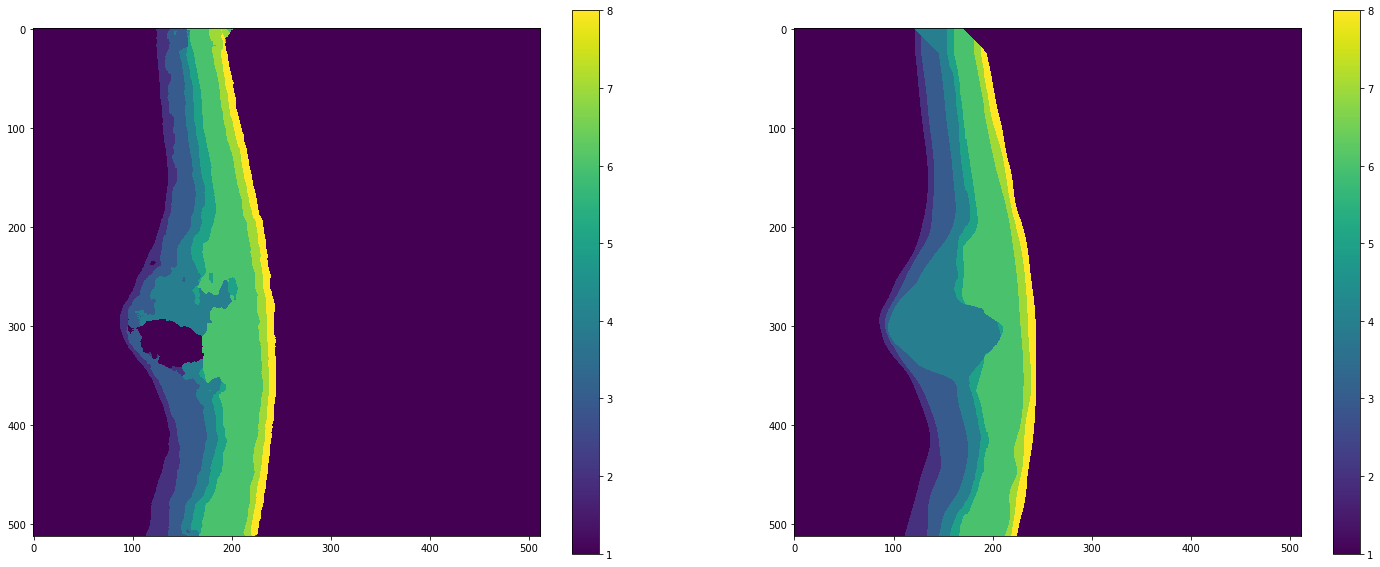

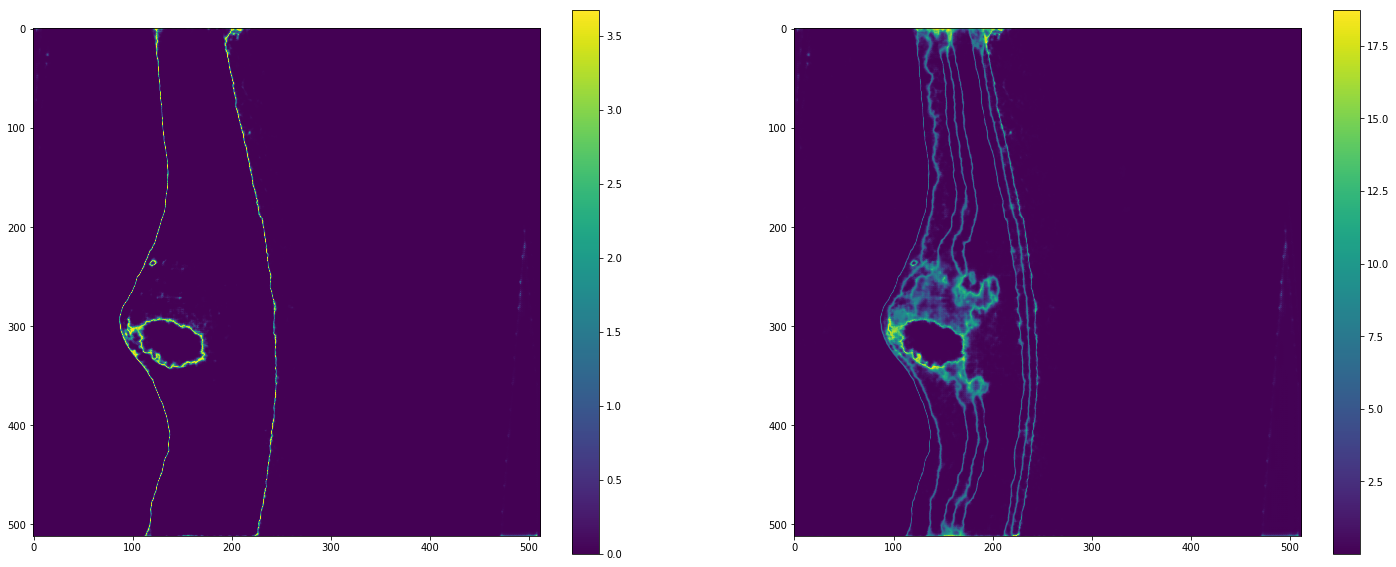

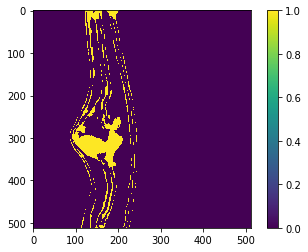

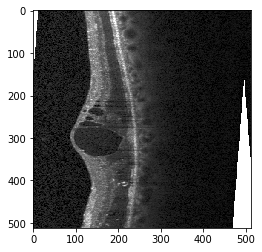

Image 17
False


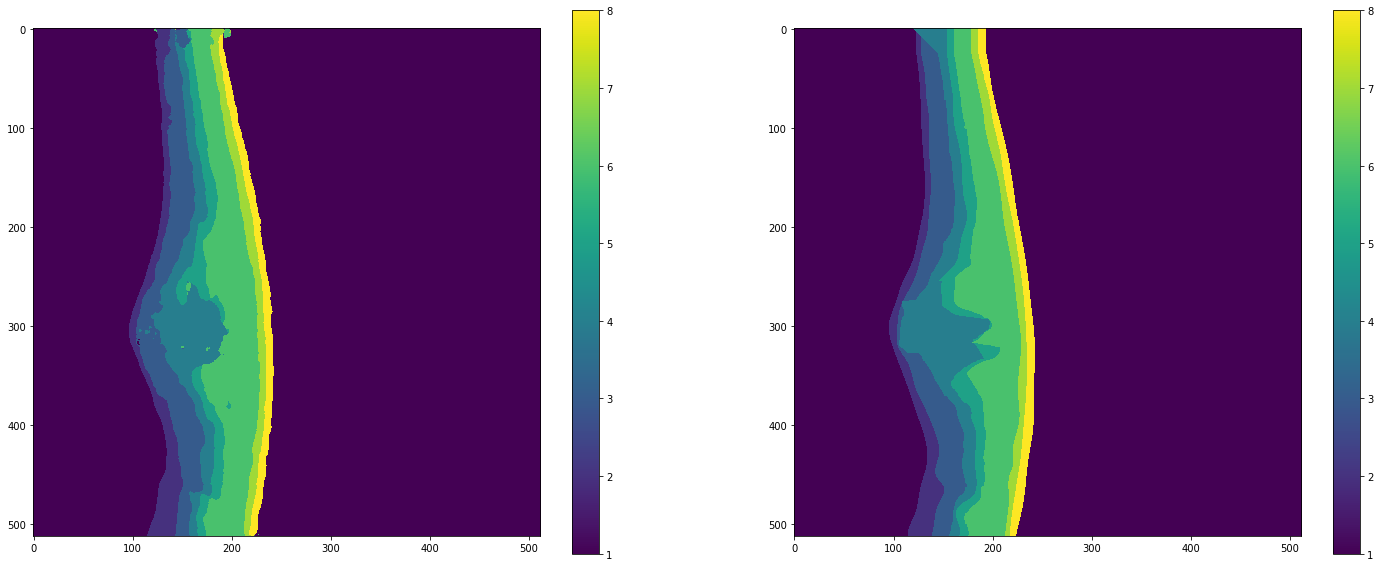

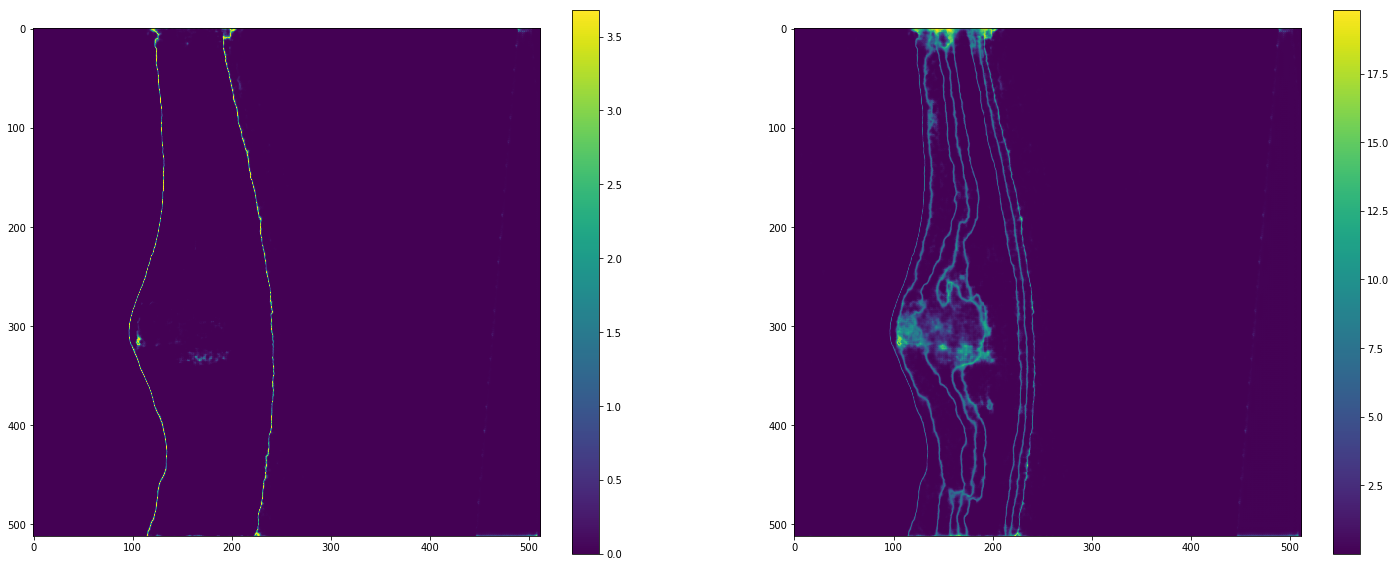

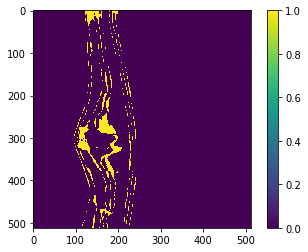

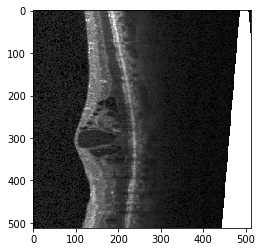

Image 18
False


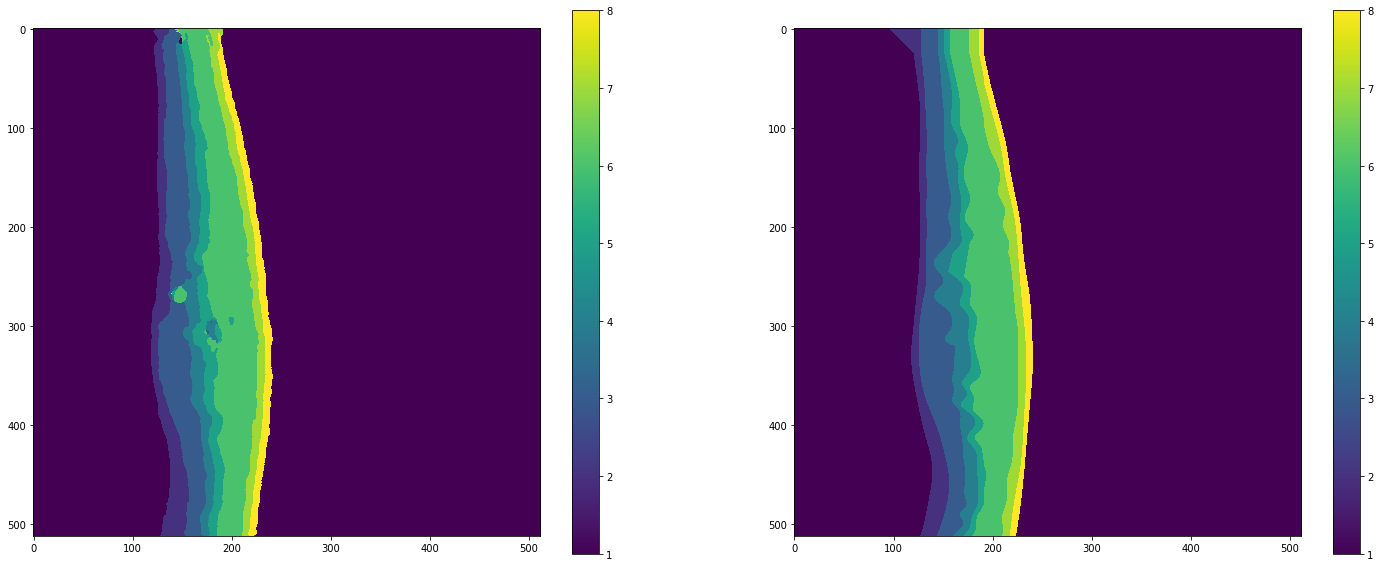

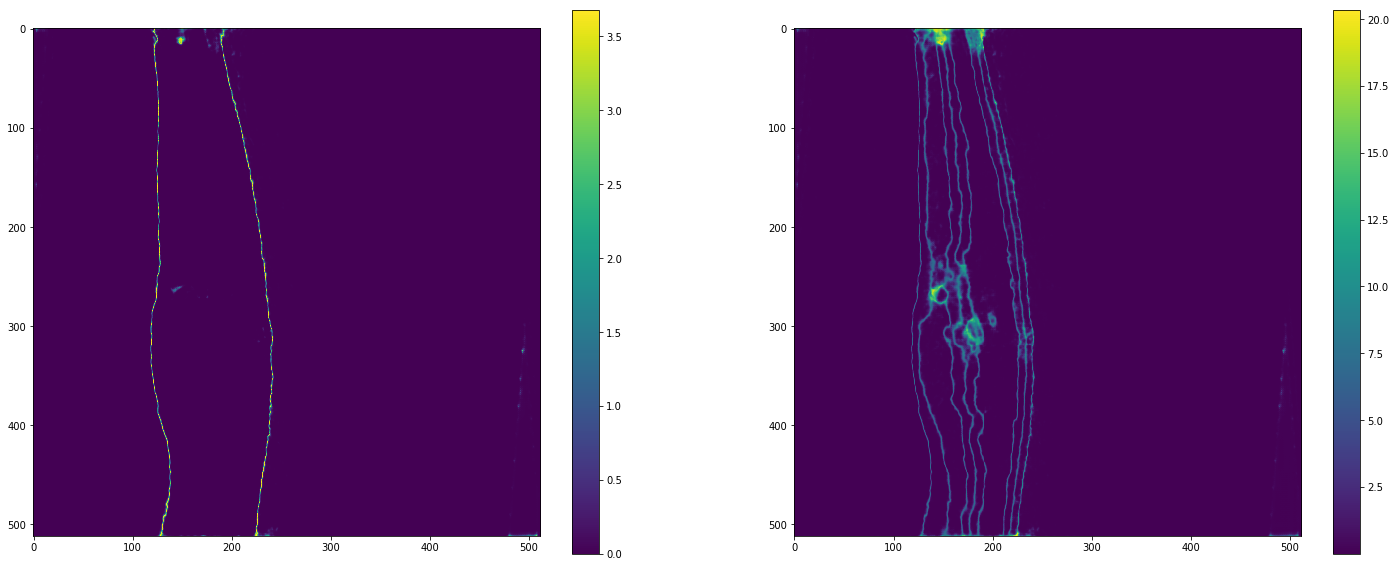

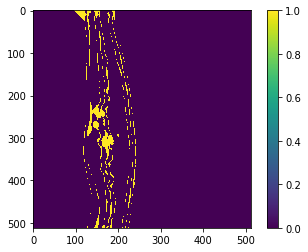

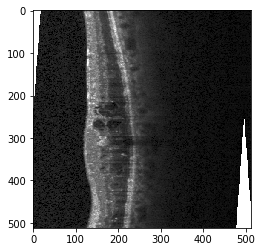

Image 19
False


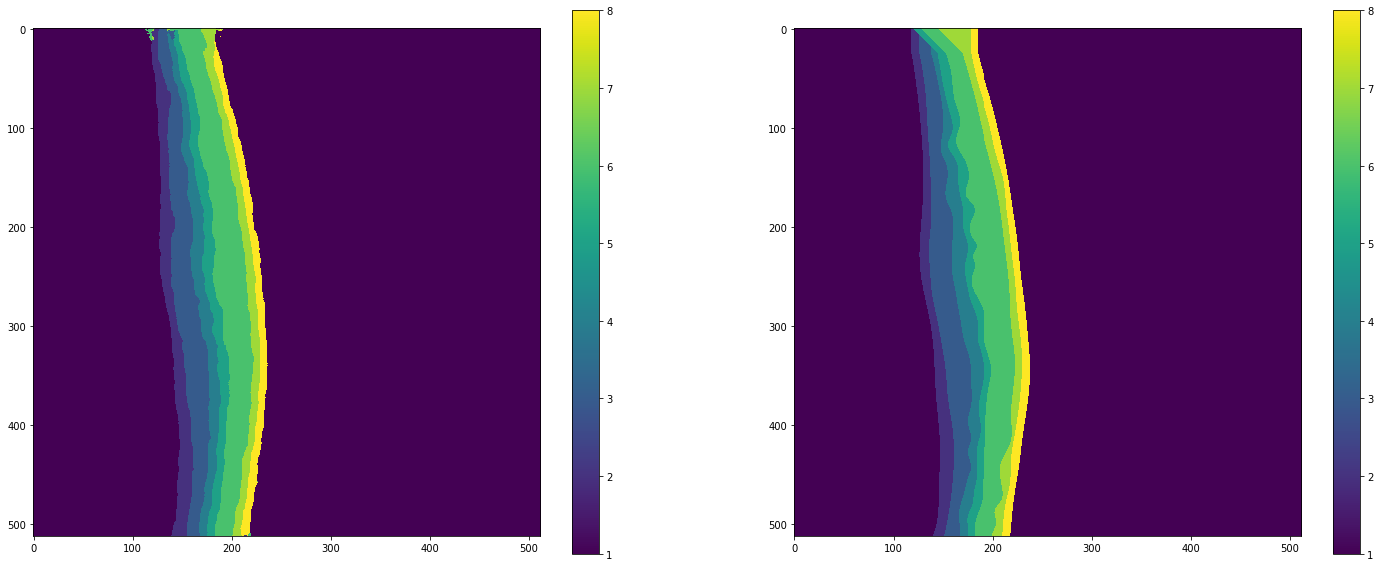

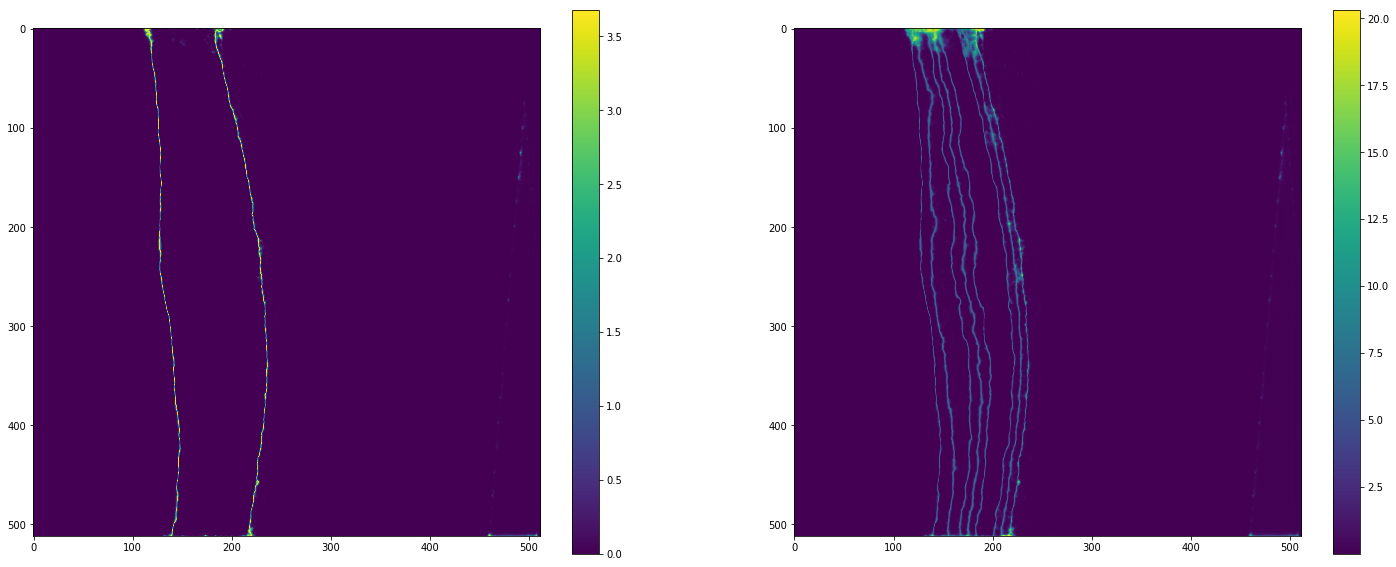

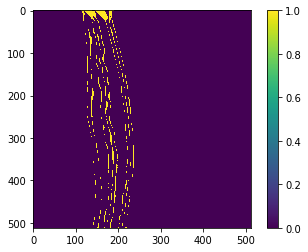

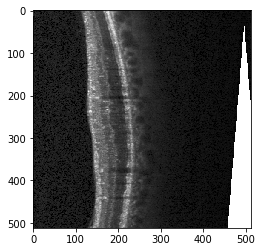

Image 20
False


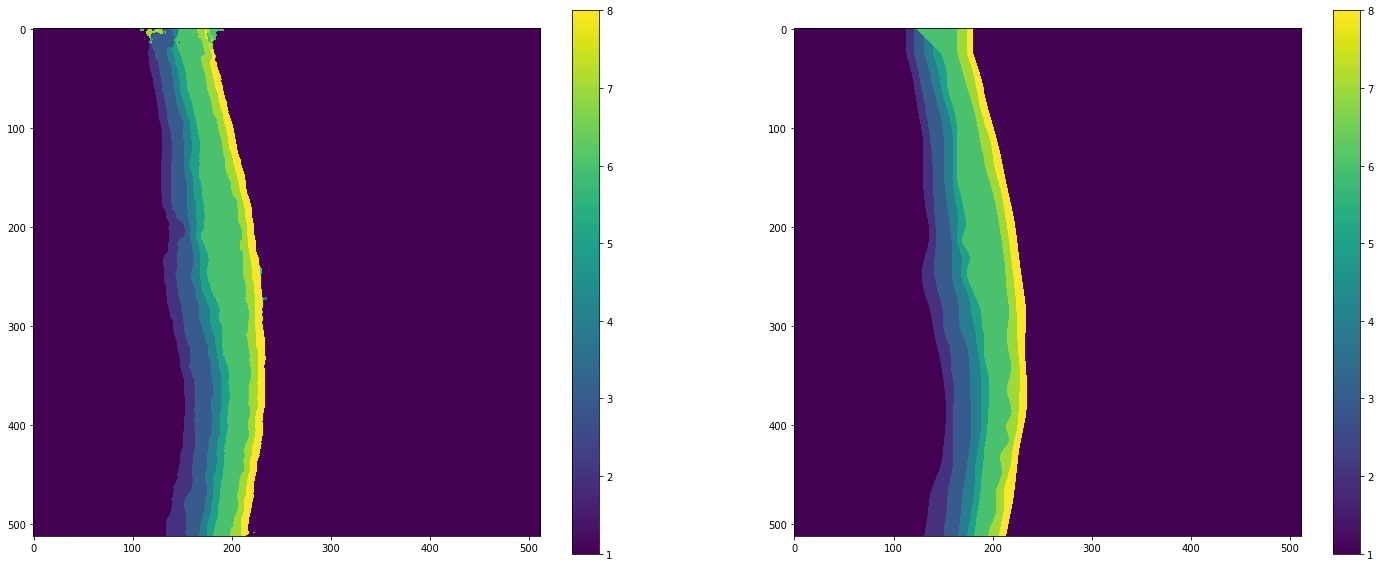

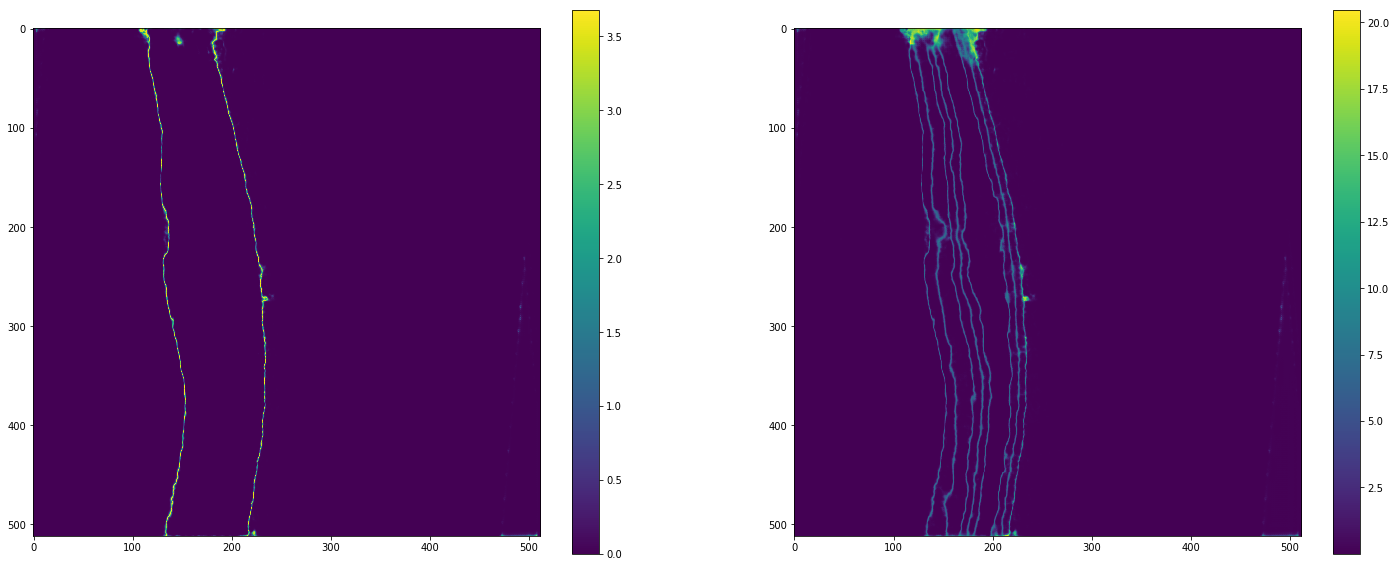

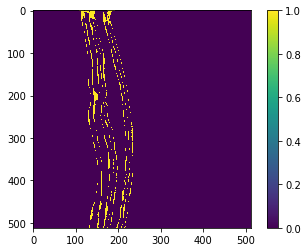

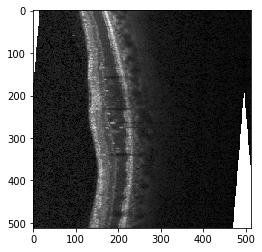

Image 21
False


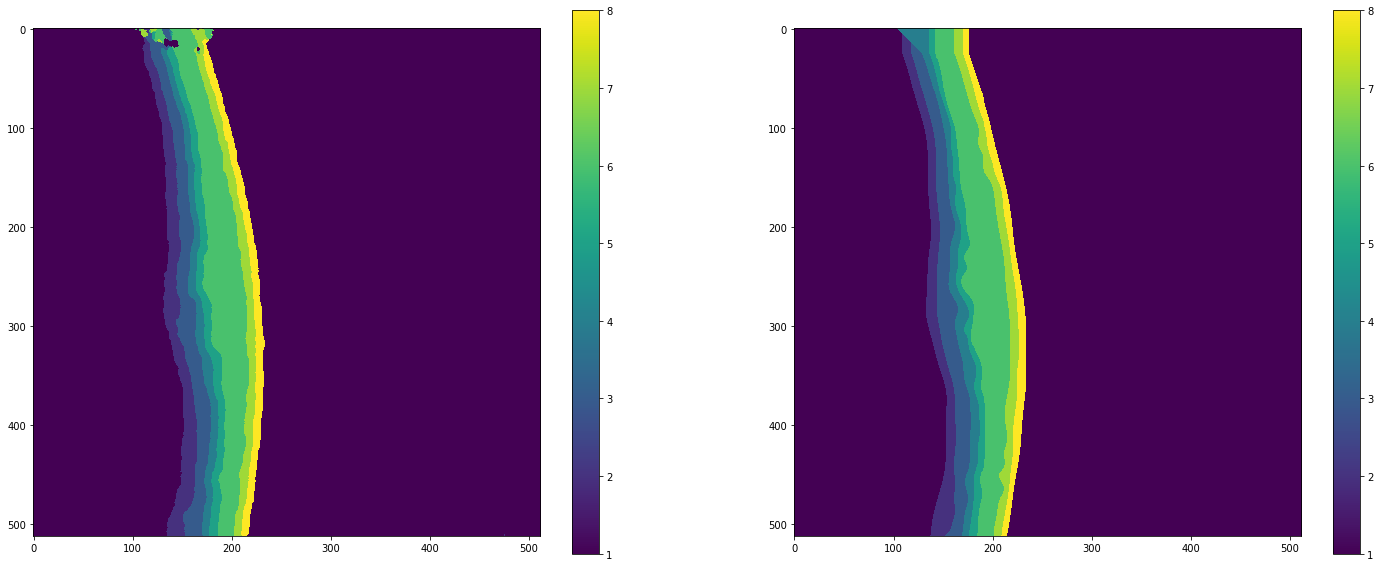

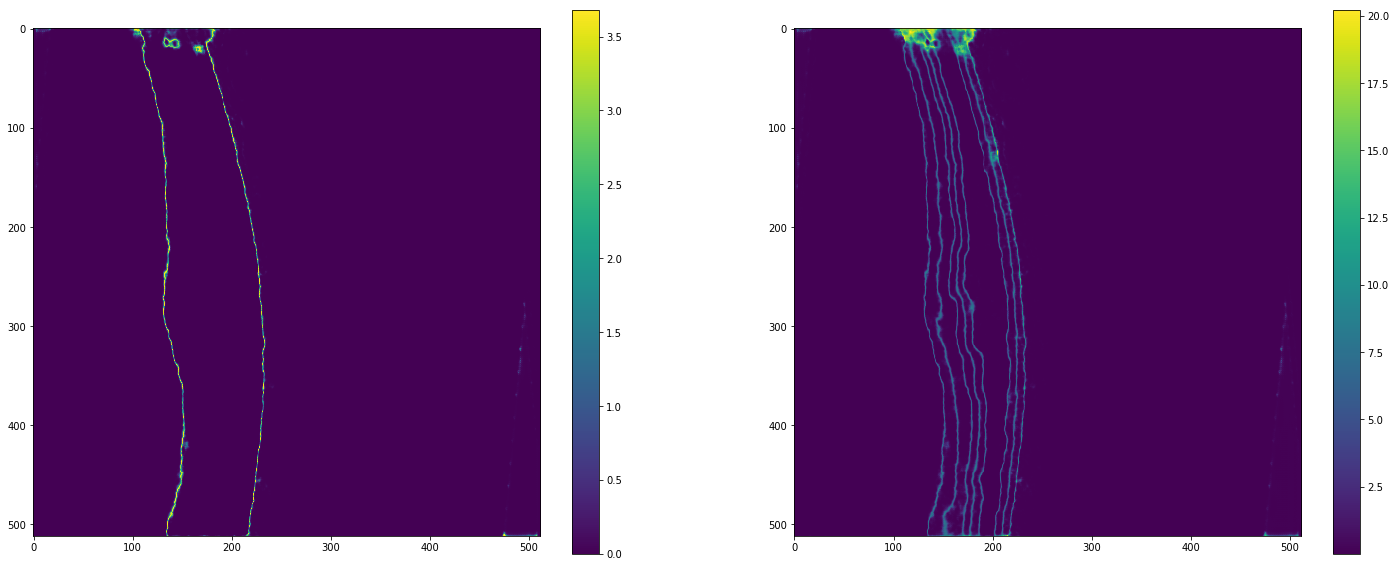

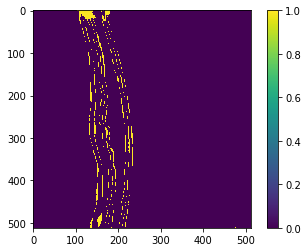

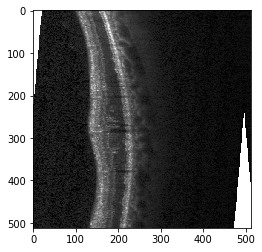

In [8]:
for i, img_test in enumerate(test_data.X):
    print('Image {}'.format(i))
    img_test = img_test[np.newaxis, :]

    avg, per_class_entropy, overall_entropy = relay_net.predict(Variable(torch.Tensor(img_test).cuda(),volatile=True))

    idx = np.argmax(avg,0)
    plt.figure(figsize=(25,10))
    plt.subplot(121)
    plt.imshow(idx)
    plt.colorbar()

    plt.subplot(122)
    y = test_data.y[i:i+1].astype(np.int)
    y[y == 9] = 1
    y = np.squeeze(y)
    print((idx == 0).all())
    plt.imshow(y)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(25,10))
    plt.subplot(121)
    plt.imshow(np.squeeze(per_class_entropy)[1])
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(np.squeeze(overall_entropy))
    plt.colorbar()
    plt.show()

    error_map = idx != y
    plt.imshow(error_map.squeeze().astype(np.int))
    plt.colorbar()
    plt.show()

    img_test = np.squeeze(img_test)
    plt.imshow(img_test, cmap='gray')
    plt.show()

number of samples: 2


/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


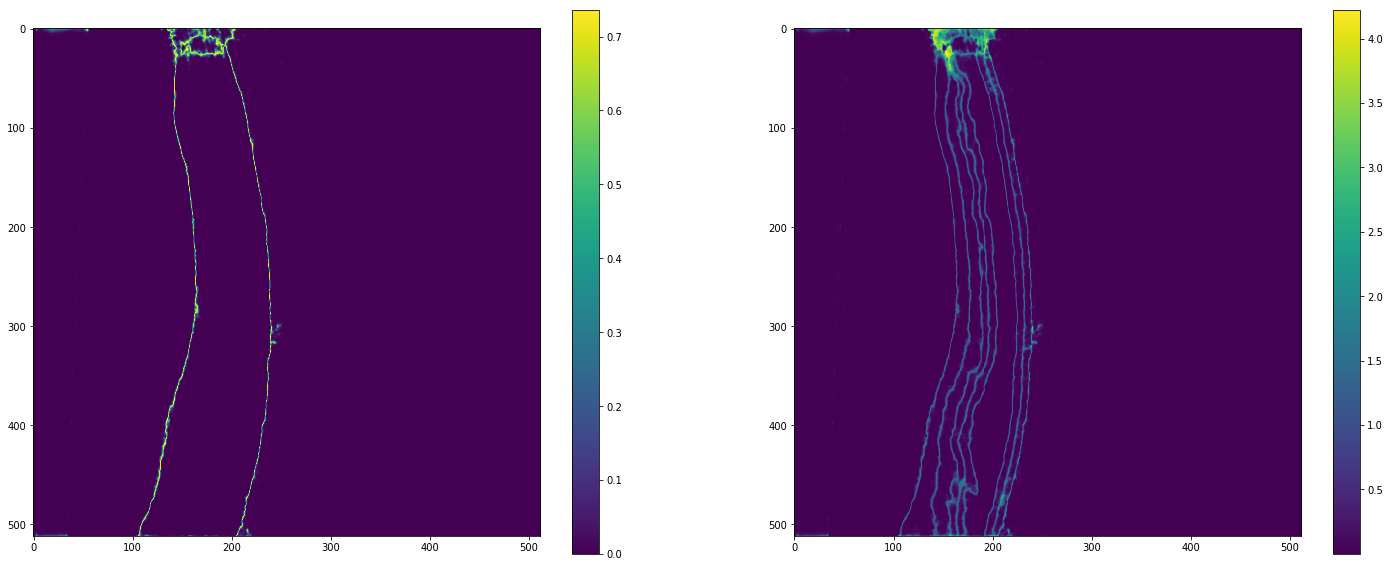

number of samples: 5


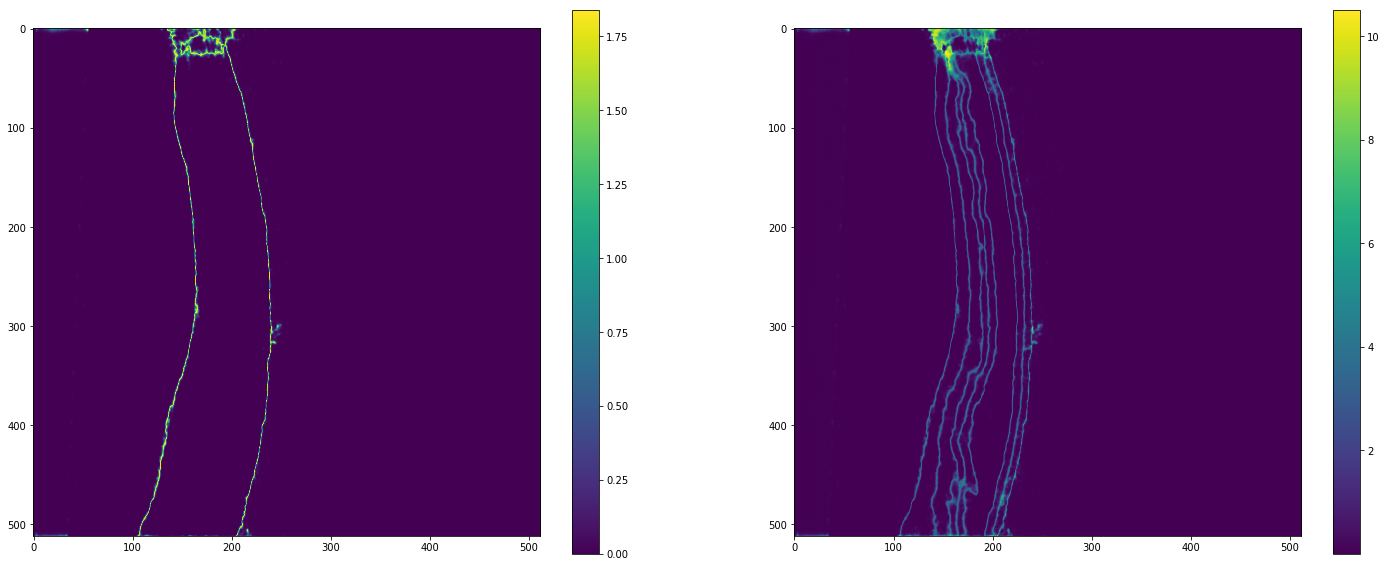

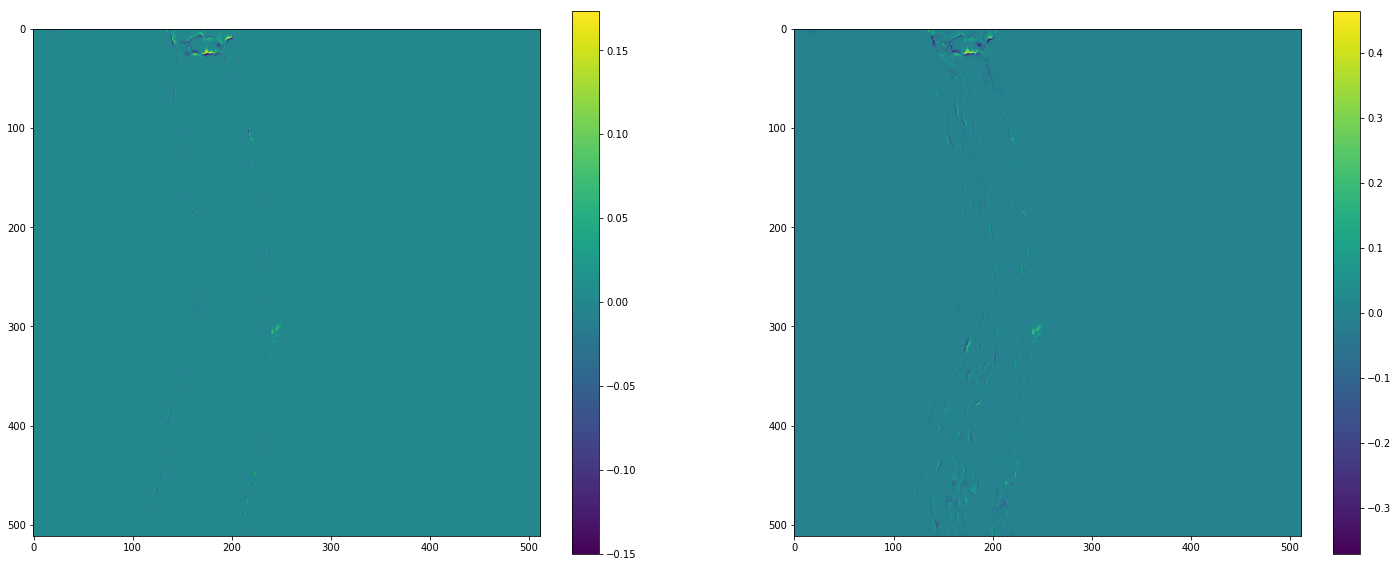

number of samples: 10


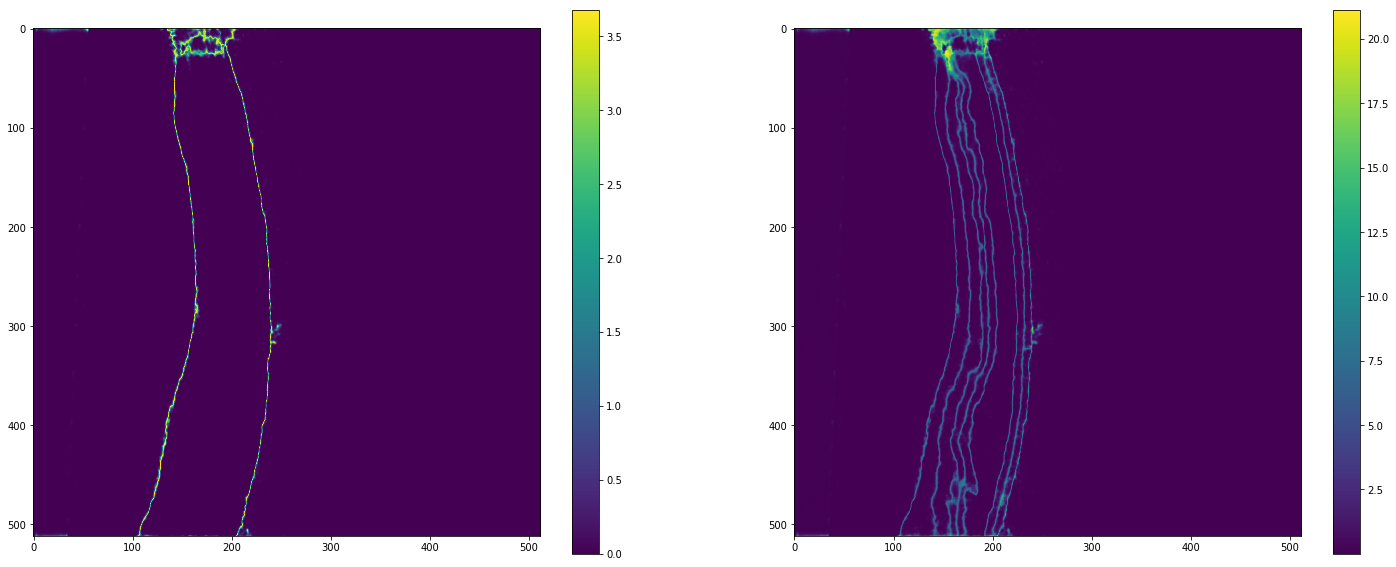

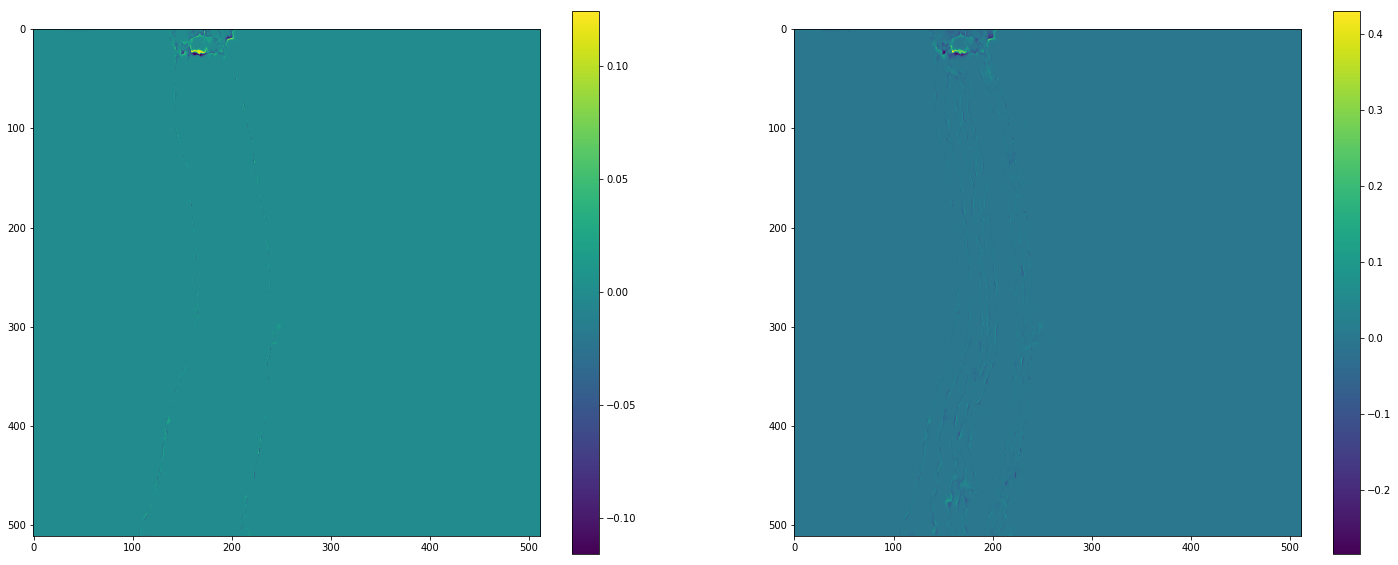

number of samples: 50


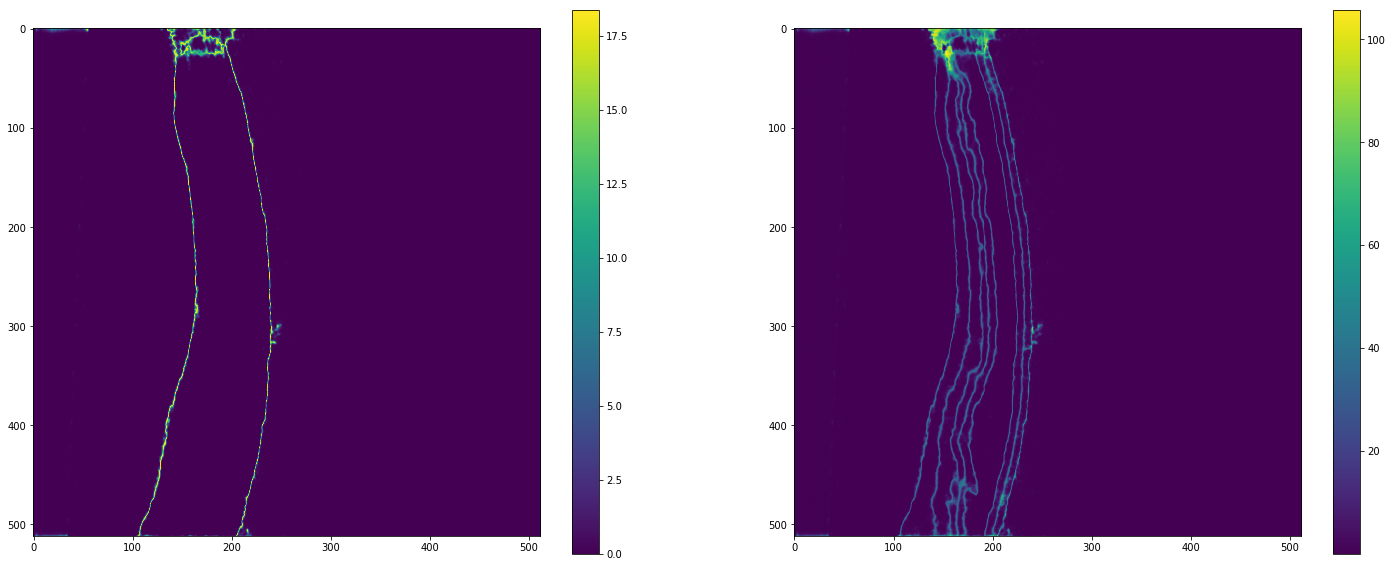

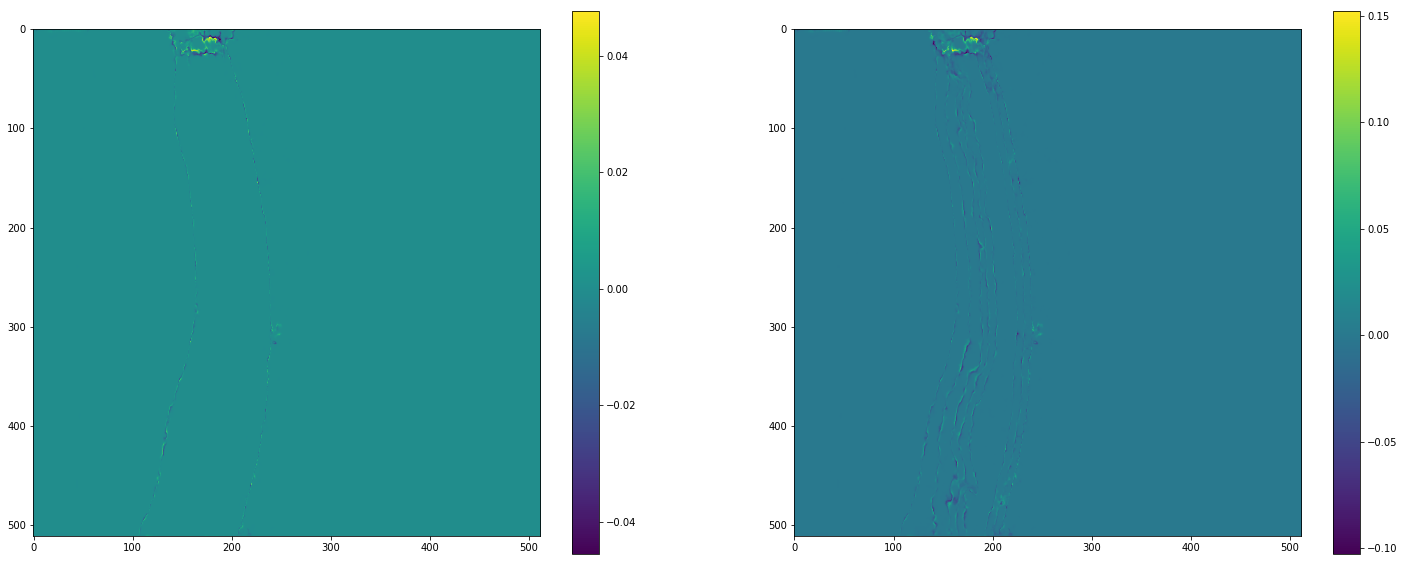

number of samples: 100


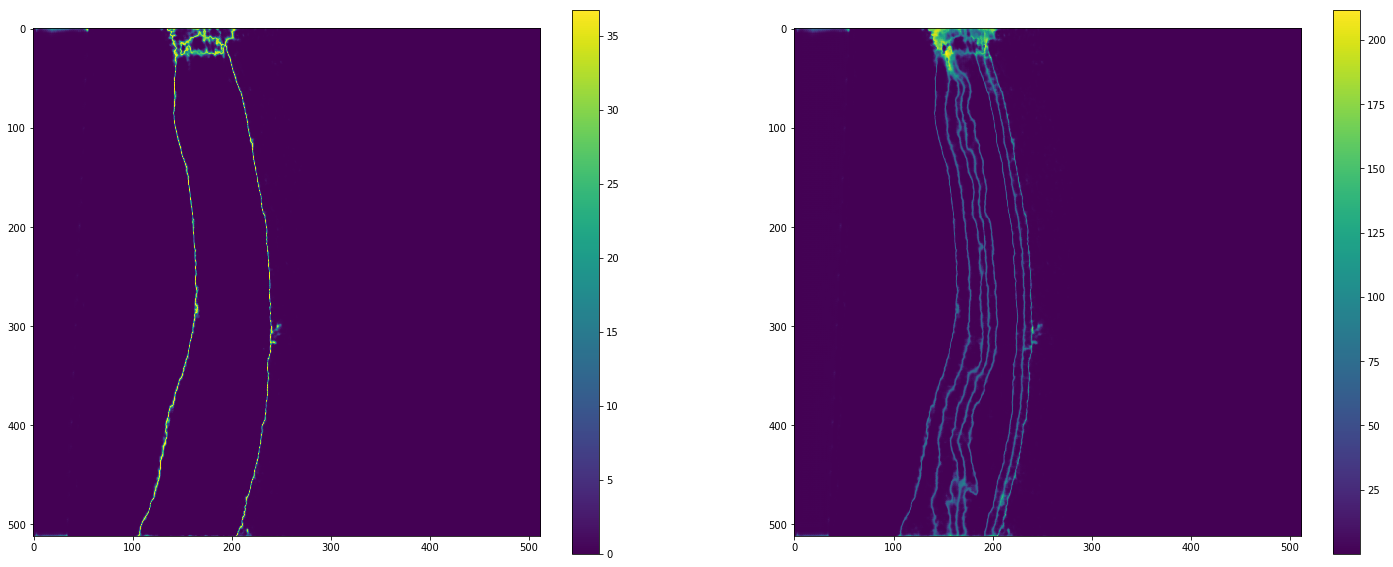

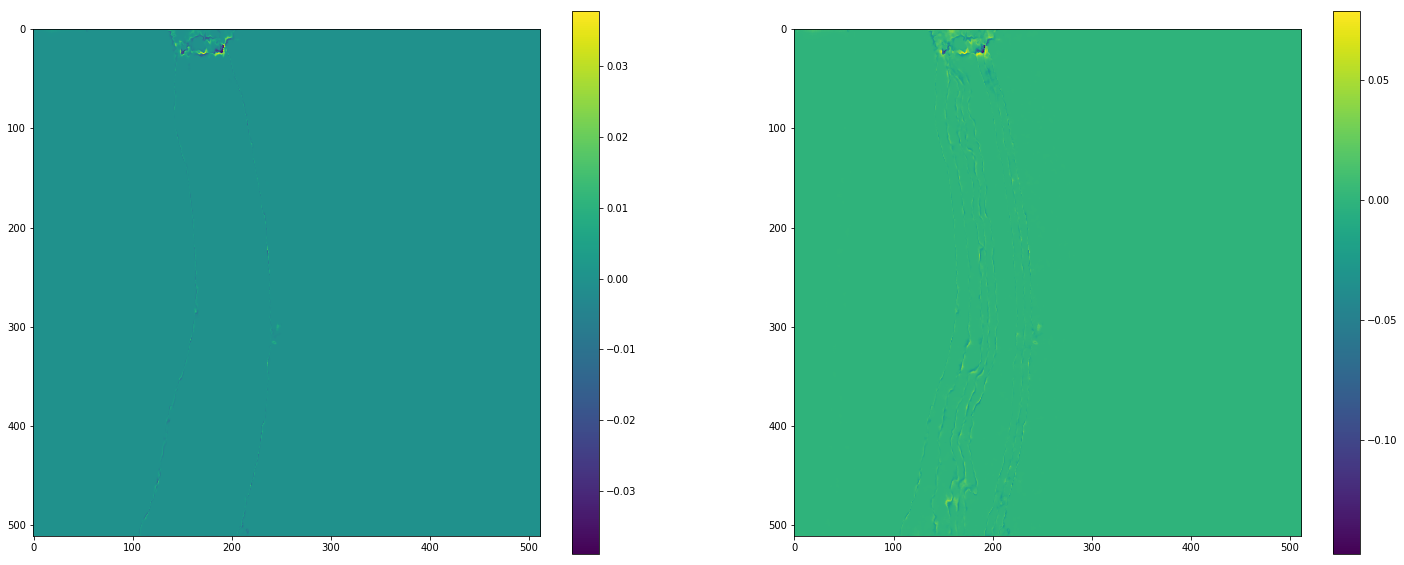

number of samples: 300


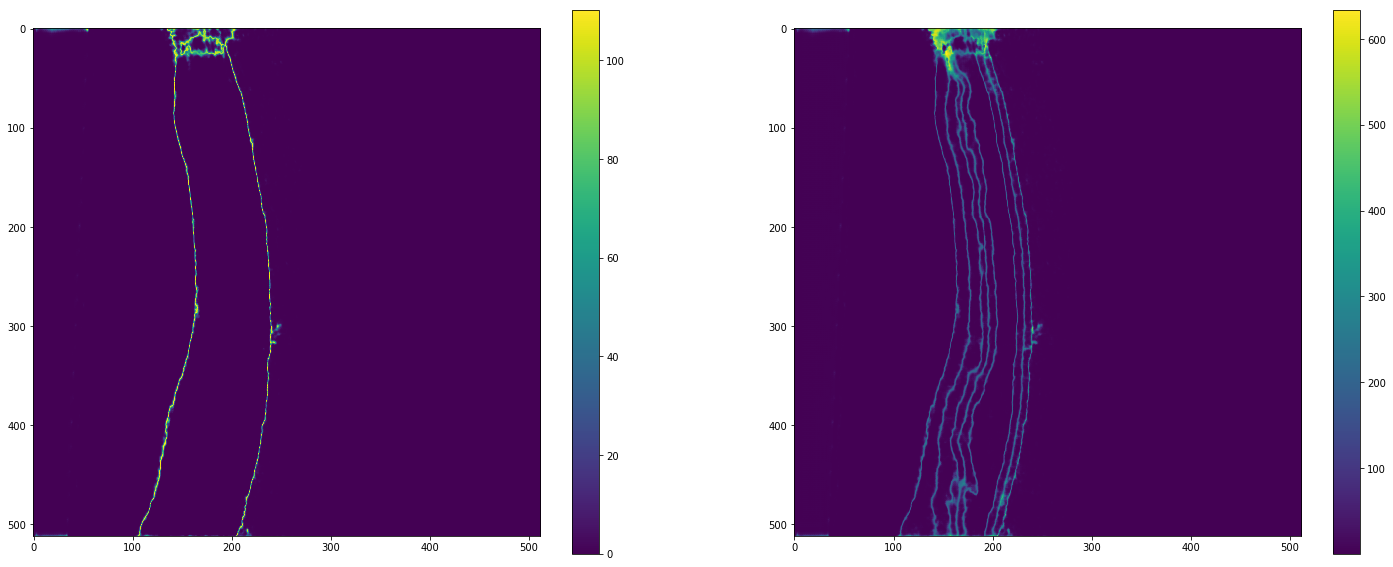

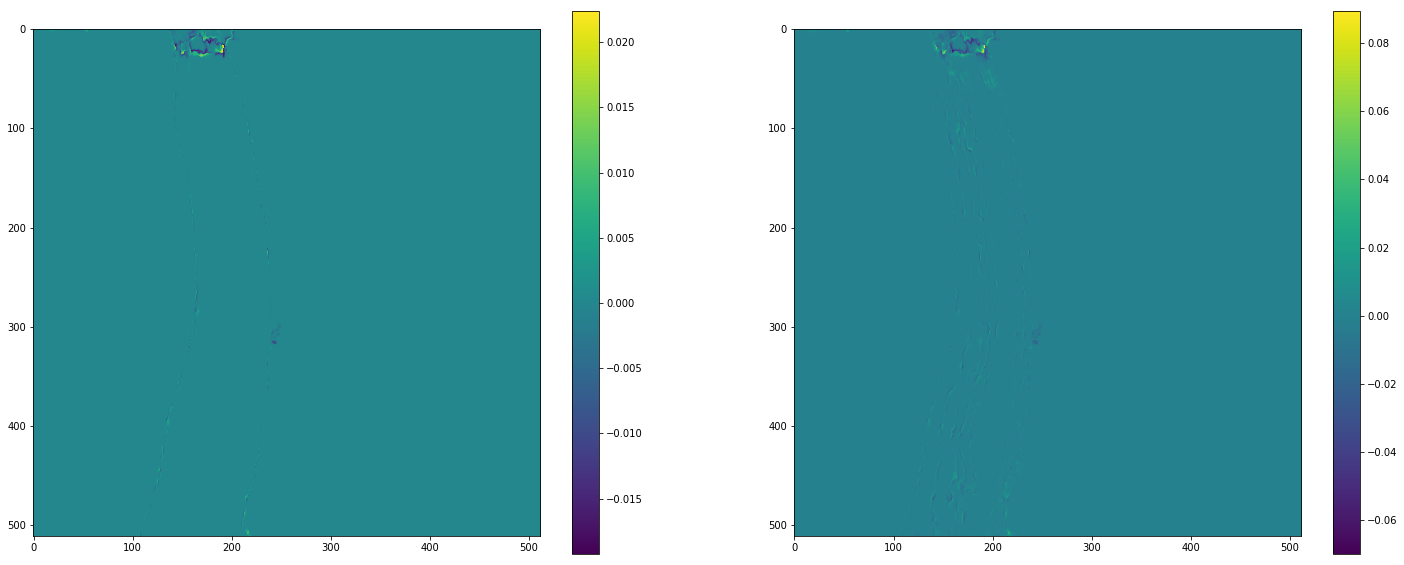

number of samples: 500


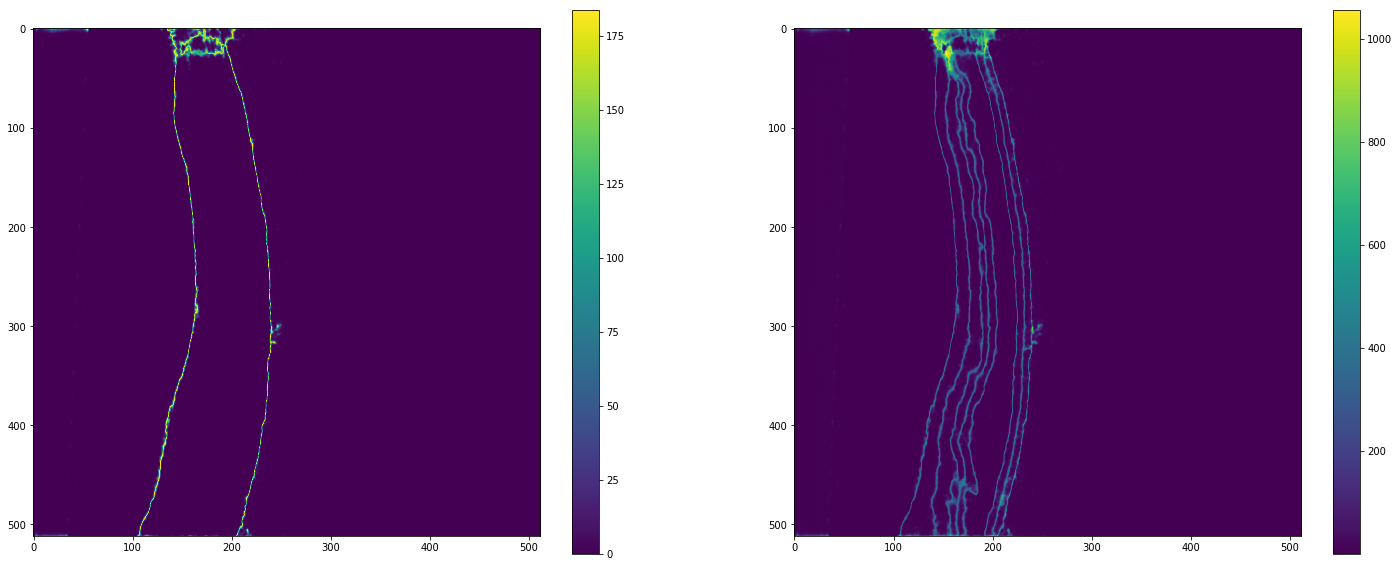

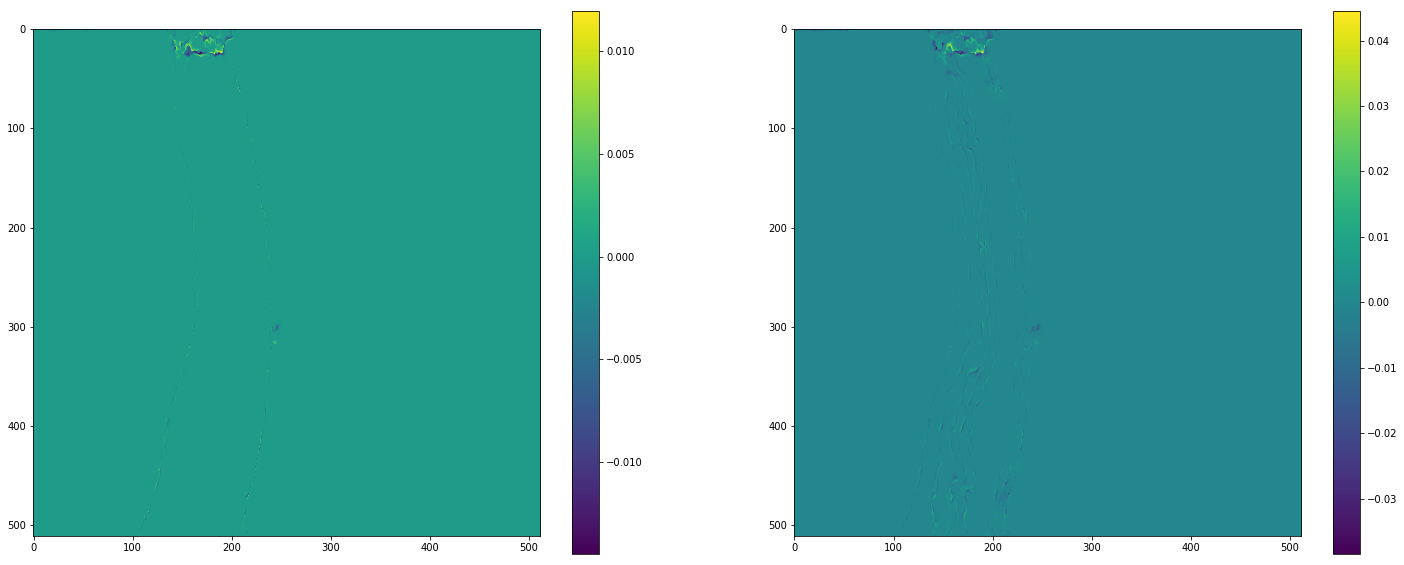

In [9]:
last = None
for i in [2, 5, 10, 50, 100, 300, 500]:
    plt.figure(figsize=(25,10))
    print('number of samples: {}'.format(i))
    avg, per_class_entropy, overall_entropy = relay_net.predict(
        Variable(torch.Tensor(test_data.X[11:12]).cuda(),volatile=True), 
        times=i)
    
    plt.subplot(121)
    plt.imshow(np.squeeze(per_class_entropy)[1])
    plt.colorbar()
    
    plt.subplot(122)
    plt.imshow(np.squeeze(overall_entropy))
    plt.colorbar()
    plt.show()
    
    if last is not None:
        plt.figure(figsize=(25,10))
        last_per_class_entropy, last_overall_entropy, last_i = last
        plt.subplot(121)
        plt.imshow(np.squeeze(per_class_entropy / i - last_per_class_entropy / last_i)[1])
        plt.colorbar()
    
        plt.subplot(122)
        plt.imshow(np.squeeze(overall_entropy / i - last_overall_entropy / last_i))
        plt.colorbar()
        plt.show()
        
    last = per_class_entropy, overall_entropy, i